# **Human Trafficking Case Study** 
<img src="https://static.wixstatic.com/media/854ff1_b8b778c28cae41198c03d9058617f0cc~mv2.png/v1/fill/w_529,h_937,al_c,q_90,enc_auto/854ff1_b8b778c28cae41198c03d9058617f0cc~mv2.png" width="300px">

- **UNODC**: (`United Nations Office on Drugs and Crime`)
- **CDE**: (`Crime Data Explorer`) 

In [1]:
import pandas as pd 
import numpy as np 
import warnings
import os 
import re 
import sqlite3 
from collections import defaultdict

import matplotlib.pyplot as plt 
import seaborn as sns 
import squarify as sq 

from matplotlib.colors import ListedColormap

from typing import List, Dict 
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 150 
pd.options.display.max_columns = 200 
plt.style.use("ggplot")

DATASET_PATH: str = os.path.join( "../datasets/HumanTrafficking/")

## **UNODC Datasets**
- `CodeBook`: https://dataunodc.un.org/sites/dataunodc.un.org/files/metadata_trafficking_in_persons.pdf
1. **Detected trafficking victims**: Number of persons identified by national authorities as having experienced the “recruitment,
transportation, transfer, harbouring or receipt of persons, by means of the threat or use of force or
other forms of coercion, of abduction, of fraud, of deception, of the abuse of power or of a position
of vulnerability or of the giving or receiving of payments or benefits to achieve the consent of a
person having control over another person, for the purpose of exploitation. Exploitation shall
include, at minimum, the exploitation of the prostitution of others or other forms of sexual exploitation, forced labour or services, slavery or practices similar to slavery, servitude or the
removal of organs.” An individual may experience various types of exploitation in one trafficking event. For example, in
the case of forced marriage, it is common for women to endure sexual and domestic exploitation, or
forced labour.
2. **Offences of trafficking in persons**: Number of offences of trafficking in persons reported in a given year in a given country.
3. **Persons brought into formal contact**: Number of persons brought into contact, suspected, arrested, investigated or cautioned for
trafficking in persons and related offenses in a given year.
4. **Persons prosecuted**: Number of persons prosecuted for trafficking in persons and related offenses in a given year.
5. **Persons convicted**: Persons found guilty by any legal body authorized to pronounce a conviction
under national criminal law, whether or not the conviction was later upheld. Persons receiving a
sentence after plea-bargaining, or in an abbreviated court procedure, should be counted as persons
convicted.

In [170]:
htf: 'DataFrame' = pd.read_excel( os.path.join(DATASET_PATH, 'data_glotip.xlsx') )
columns: List[str]  = htf.iloc[1].tolist()
htf = htf.iloc[2:]
htf.columns = columns
htf['Value' ] = htf['txtVALUE'].replace({"<5": "4"}).apply(lambda row: row.replace(",", "") ).astype(int)
country_origins: List[str] = htf.query("Indicator == 'Detected trafficking victims' ").groupby('Country')['Value'].sum().sort_values(ascending=False).head(10).index.tolist() 

htf.head() 

Iso3_code      Country    Region                        Subregion  \
2       ABW        Aruba  Americas  Latin America and the Caribbean   
3       AFG  Afghanistan      Asia                    Southern Asia   
4       AFG  Afghanistan      Asia                    Southern Asia   
5       AFG  Afghanistan      Asia                    Southern Asia   
6       AFG  Afghanistan      Asia                    Southern Asia   

                             Indicator                   Dimension Category  \
2         Detected trafficking victims  by country of repatriation  Ukraine   
3         Detected trafficking victims  by country of repatriation   Abroad   
4         Detected trafficking victims  by country of repatriation   Abroad   
5   Offences of trafficking in persons                       Total    Total   
6  Persons brought into formal contact                       Total    Total   

     Sex    Age  Year Unit of measurement txtVALUE  Source  Value  
2  Total  Total  2010              Counts       <5  GLOTIP      4  
3  Total  Total  2003              Counts       <5  GLOTIP      4  
4  Total  Total  2008              Counts       <5  GLOTIP      4  
5  Total  Total  2013              Counts      103  GLOTIP    103  
6  Total  Total  2013              Counts      167  GLOTIP    167

## **Boxplot**: Human Trafficking Indicators by `Top 10 Country`

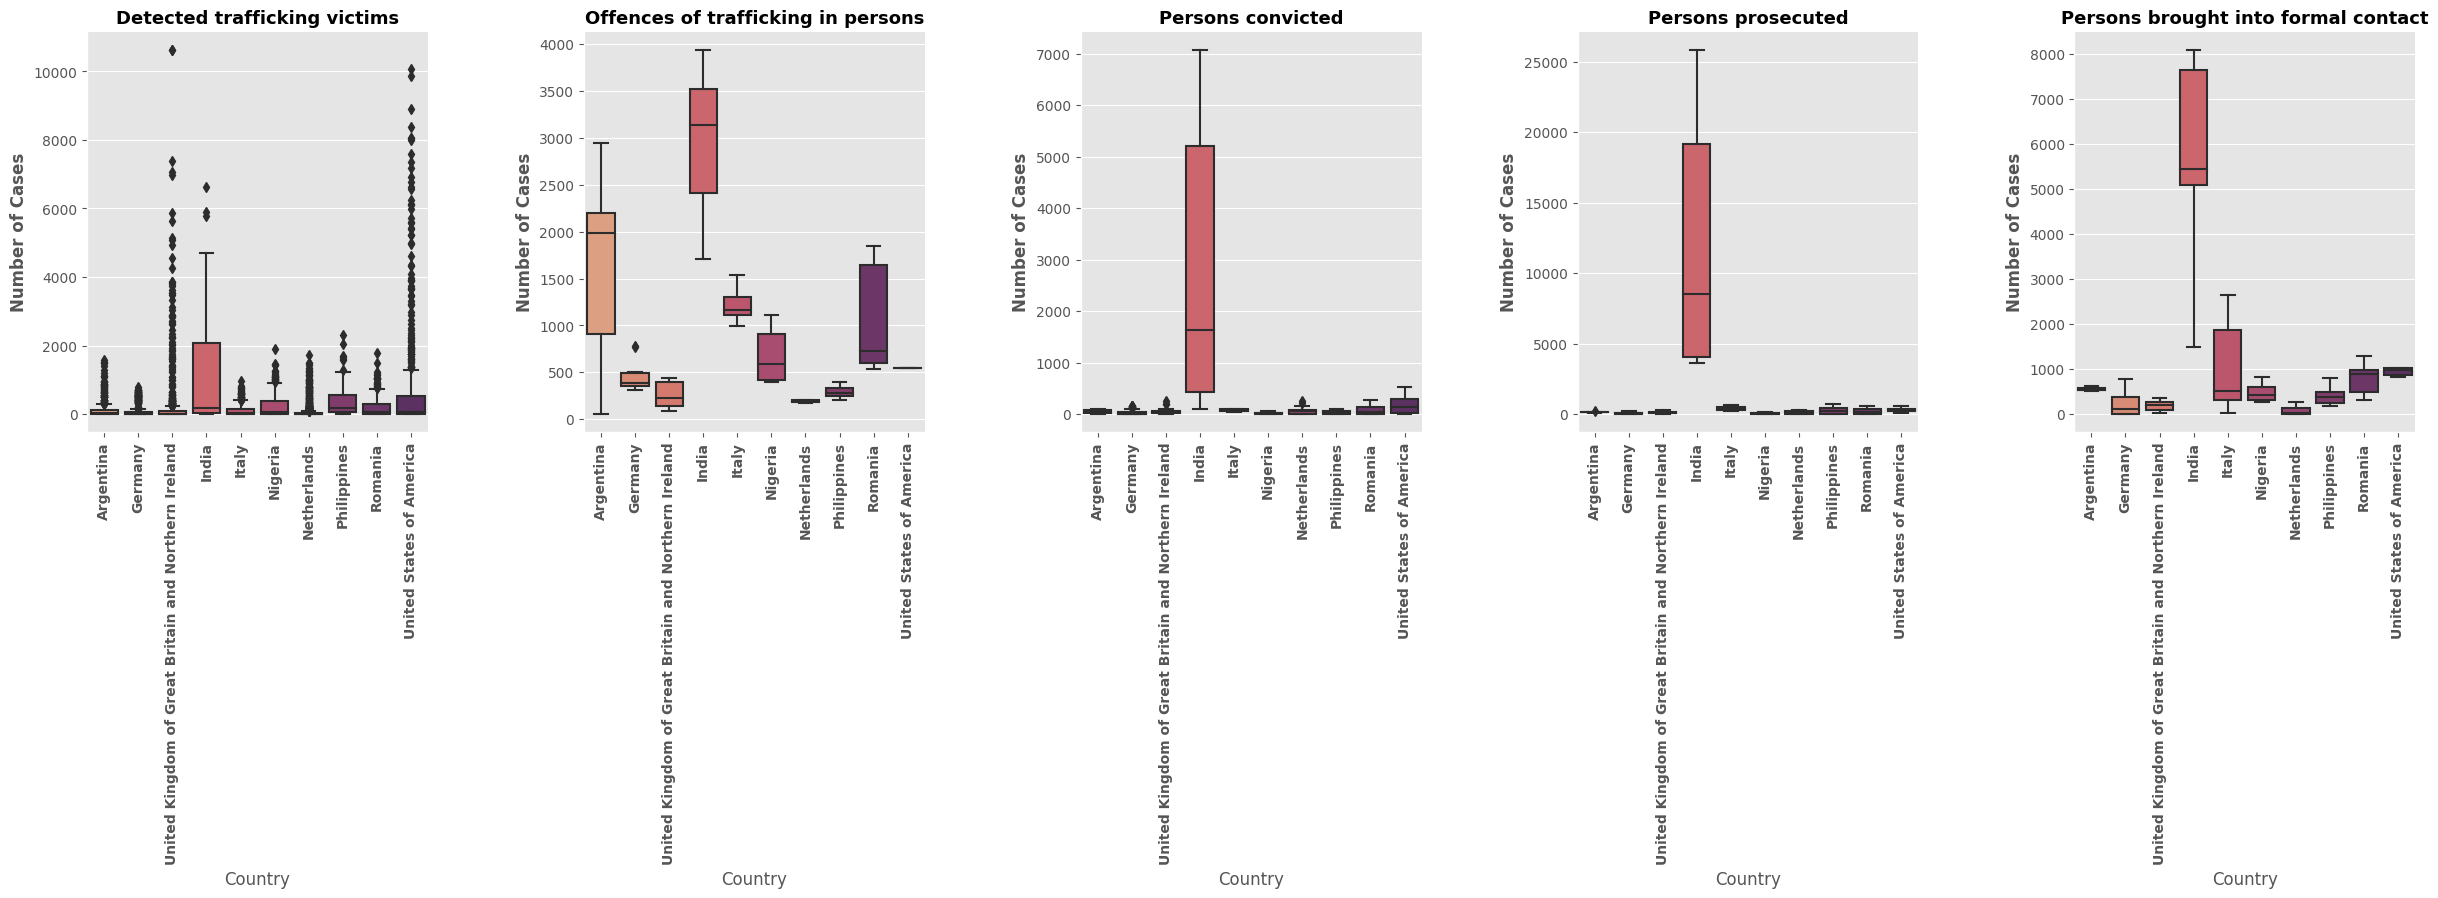

In [206]:
axs = sns.catplot(data=htf[htf['Country'].isin(country_origins)], col='Indicator', x='Country', y='Value', kind='box', sharey=False, palette='flare')
for ax in axs.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold')
    ax.set_ylabel("Number of Cases", fontweight='bold' )
    ax.set_title(ax.get_title().replace("Indicator = ", "").strip(), fontweight='bold', fontsize=13 )
    
axs.tight_layout() 

## **Distribution of Number of Trafficking Victims**

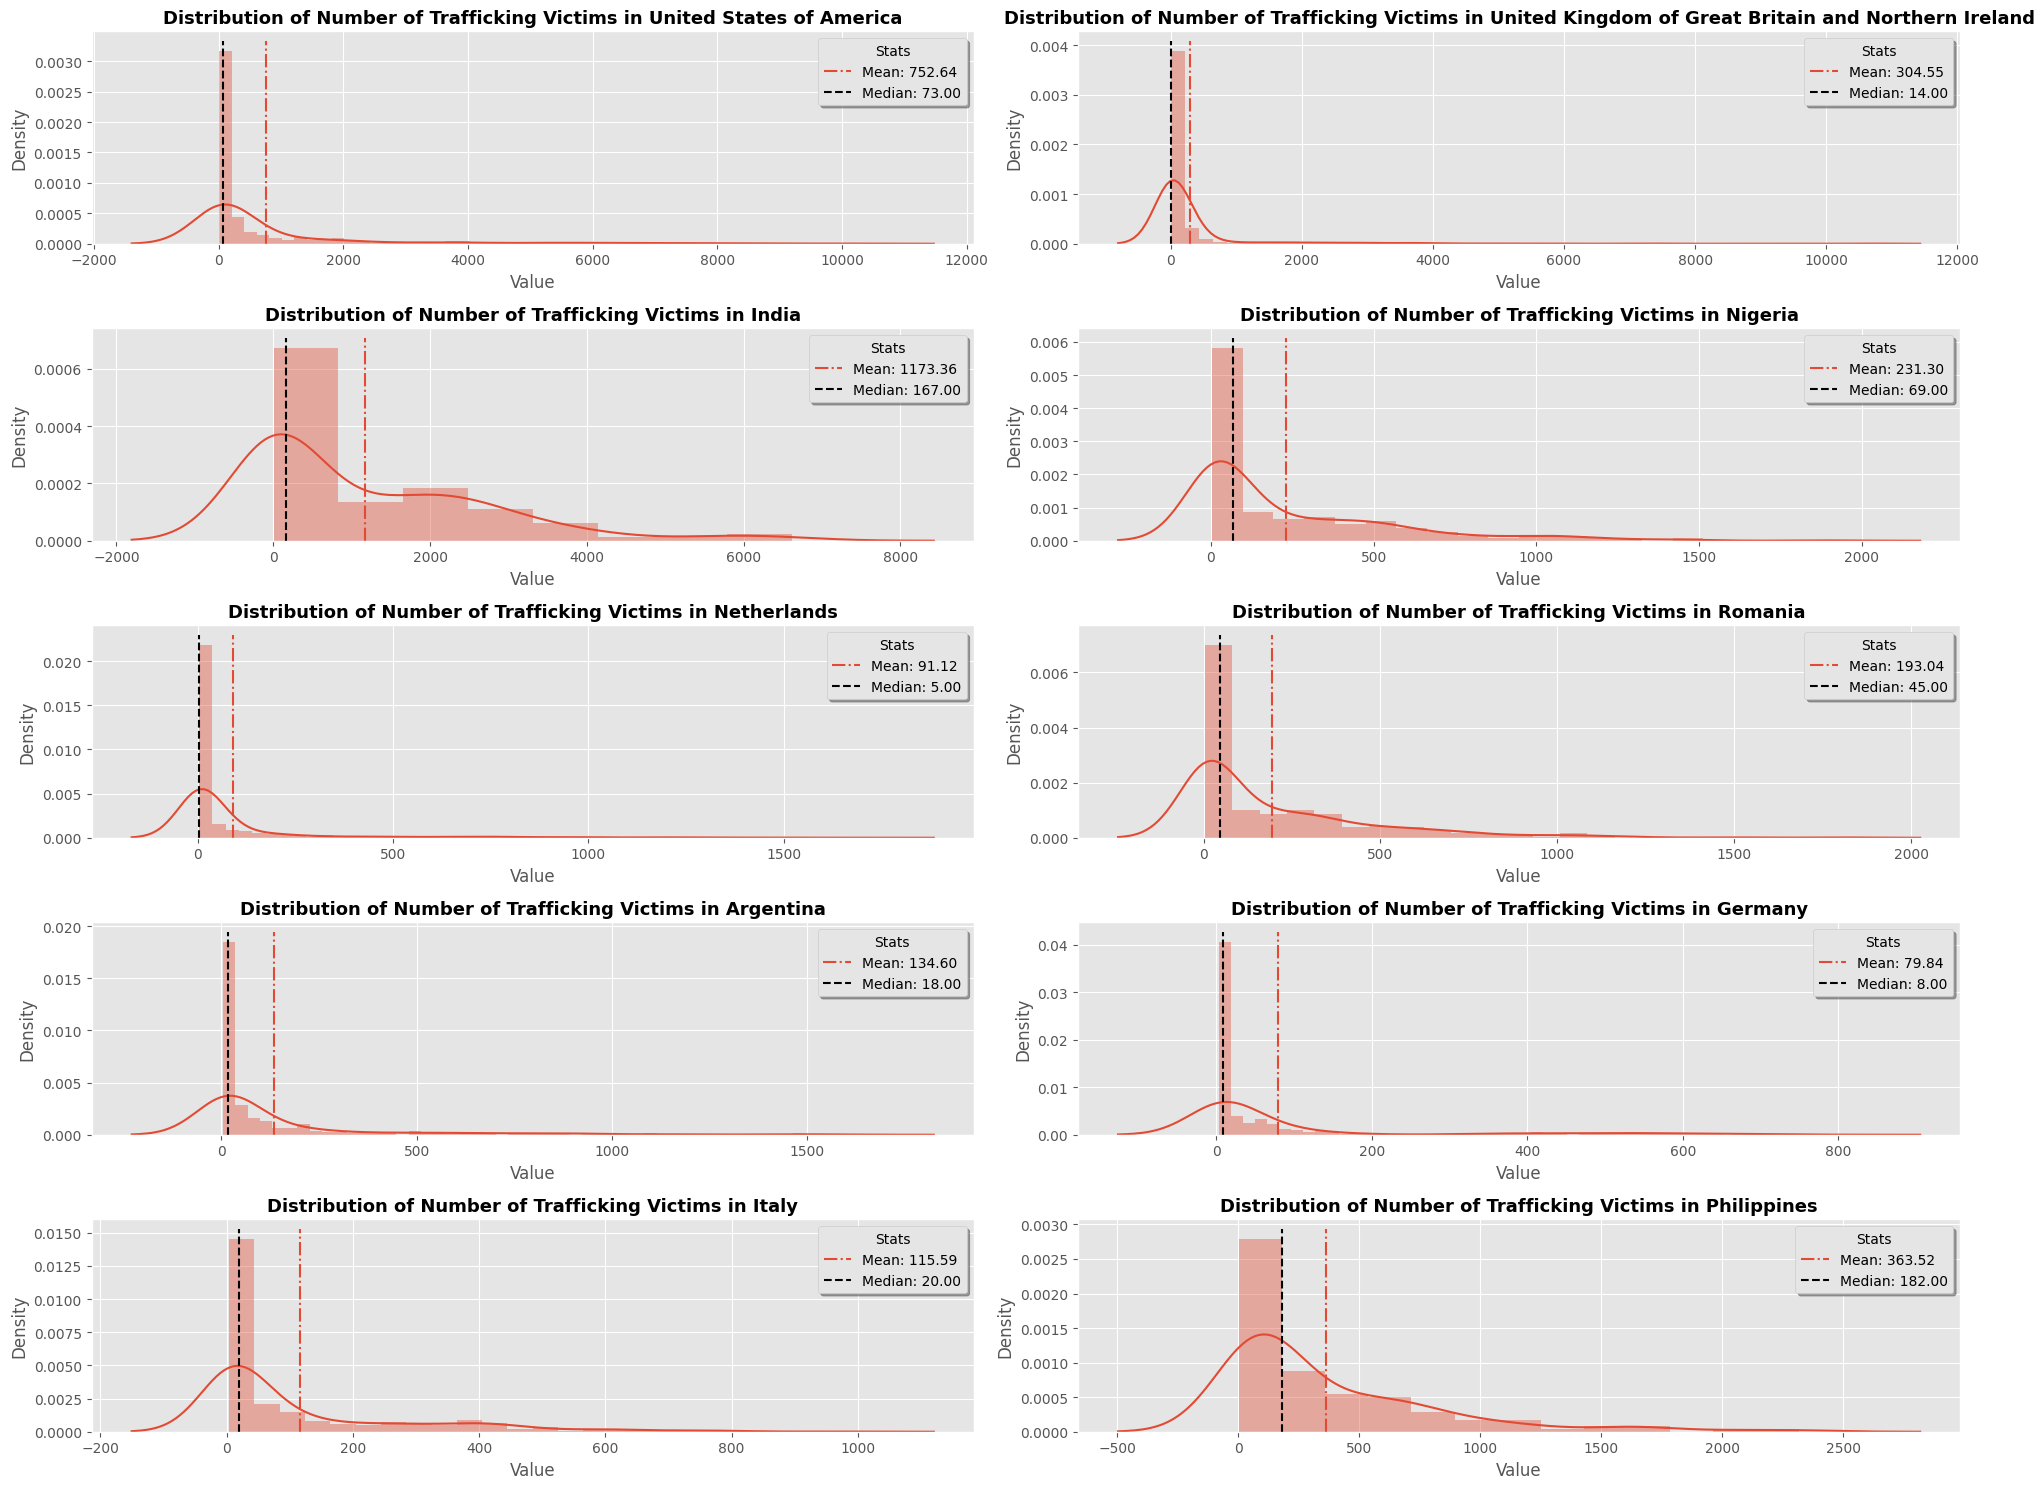

In [215]:
fig = plt.figure(figsize=(20,15)) 

for index,country in enumerate(country_origins, 1):
    ax = fig.add_subplot(5,2,index)
    df: 'Series' = htf.query(f"Country == '{country}' and Indicator == 'Detected trafficking victims'  ")['Value']
    sns.distplot( df, ax=ax )
    
    ax.set_title("Distribution of Number of Trafficking Victims in %s" % (country), fontweight='bold', fontsize=13)
    mean: float = df.mean() 
    median: float = df.median() 
    ymin,ymax = ax.get_ylim() 

    ax.vlines(mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle="-.")
    ax.vlines(median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle="--", color='black')
    ax.legend(title="Stats", fancybox=True, shadow=True) 
    
plt.tight_layout()

In [217]:
# Total Number of Trafficking Victims By Country, Years 
indicators: List[str] = htf['Indicator'].unique().tolist() 

## **Number of Trafficking Victims By Country**

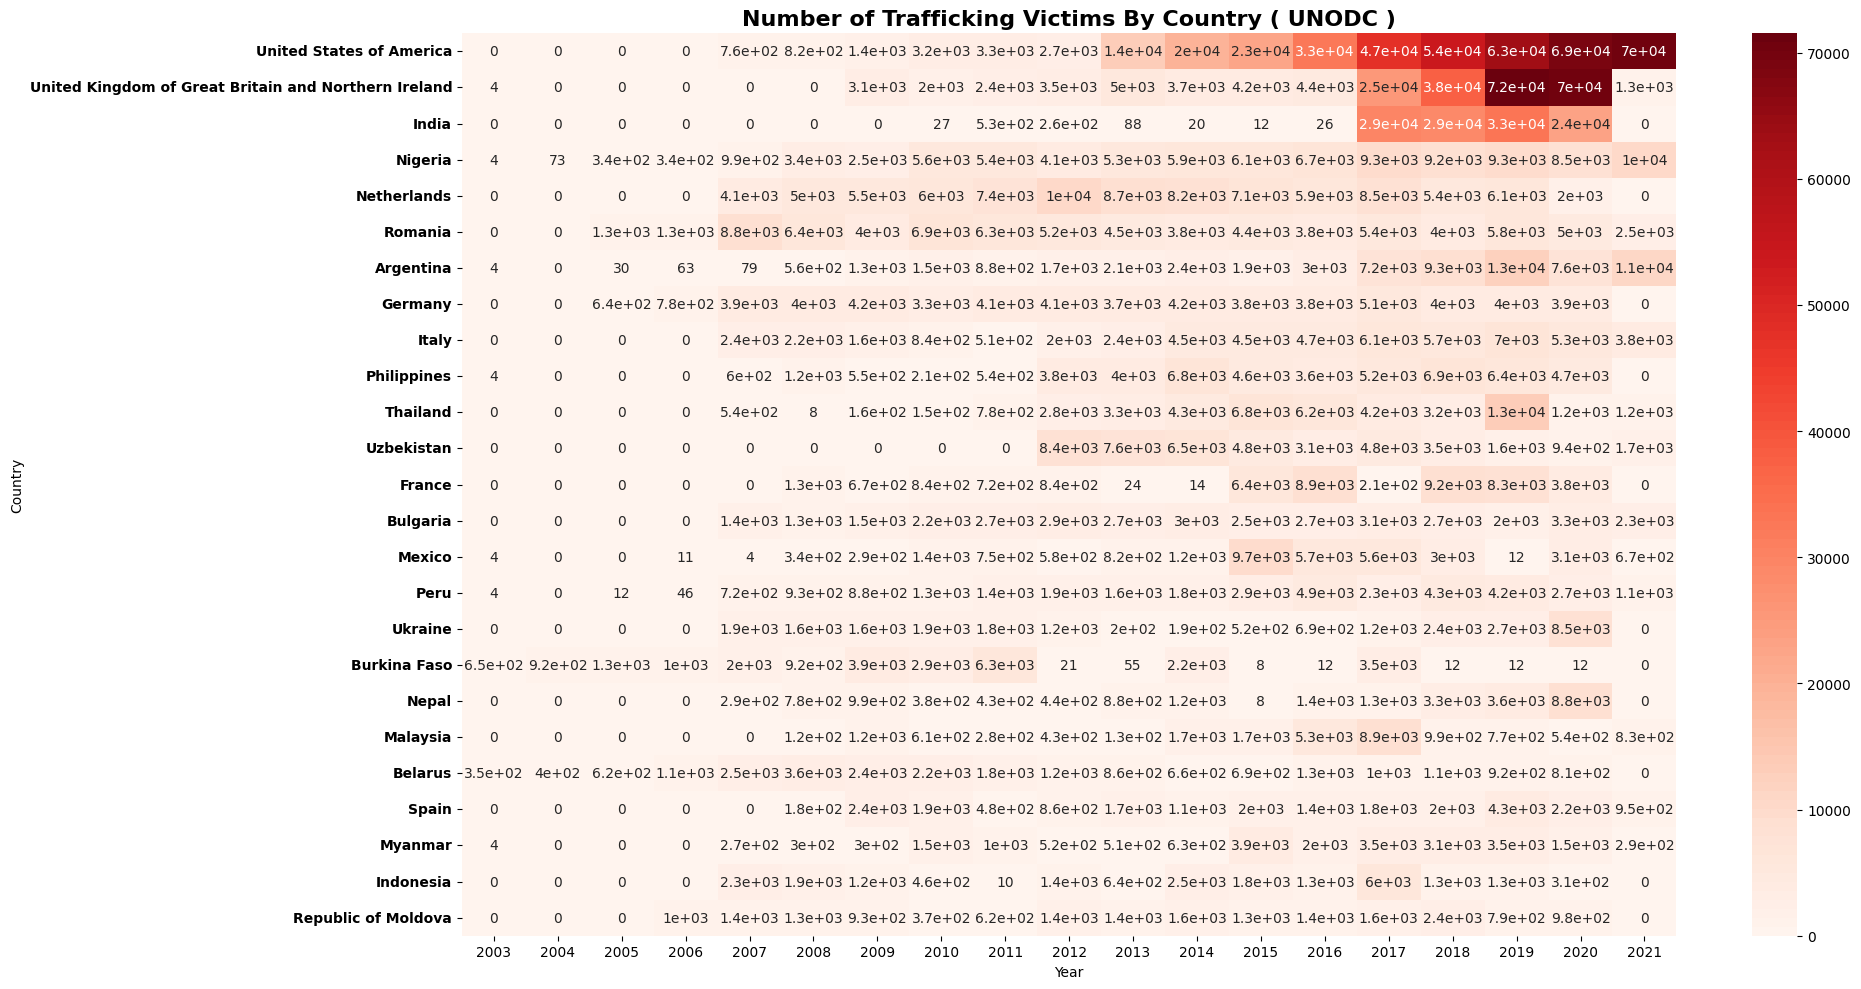

In [153]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot() 
sns.heatmap(htf.query("Indicator == 'Detected trafficking victims' ").groupby(['Year', 'Country'])['Value'].sum().unstack("Year").replace({np.nan:0.0}).loc[country_origins],
            ax=ax, 
            cmap=ListedColormap(sns.color_palette(palette='Reds', n_colors=100)), 
            annot=True
           )  # UNODC 

ax.set_title("Number of Trafficking Victims By Country ( UNODC )" , fontweight='bold', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.tight_layout() 

## **Additional Information** 
- **Note**: `Languages`, `Religions`

In [109]:
additinal_info: 'DataFrame' = pd.read_csv(os.path.join(DATASET_PATH, "AllCountries.csv") )
country_info: 'DataFrame' = pd.DataFrame(additinal_info.index.tolist()[:-14][1:], columns=additinal_info.index.tolist()[:-14][0] )
country_info.head()

ROG3            Ctry PoplPeoples CntPeoples CntPeoplesLR PoplPeoplesLR  \
0   AF     Afghanistan    42135000         70           68      42133000   
1   AL         Albania     2800000         15            3         39000   
2   AG         Algeria    45521000         38           34      45487000   
3   AQ  American Samoa       43000          9            1           800   
4   AN         Andorra       79000         10            2          1200   

  JPScaleCtry ROL3OfficialLanguage      OfficialLang RLG3Primary  \
0           1                  pbt  Pashto, Southern           6   
1           2                  aln    Albanian, Gheg           6   
2           1                  arb  Arabic, Standard           6   
3           5                  smo            Samoan           1   
4           3                  cat           Catalan           1   

  ReligionPrimary PercentChristianity PercentEvangelical 10_40Window ROG2  \
0           Islam    0.01717568505688  0.014293101193637           Y  ASI   
1           Islam     33.677355517469   0.61188788975755           Y  EUR   
2           Islam   0.076112587236723  0.045811593588587           Y  AFR   
3    Christianity     95.422429497083    25.196447606216           N  SOP   
4    Christianity     90.595400299926     1.364684693558           N  EUR   

  Continent RegionCode                     RegionName PercentUrbanized  \
0      Asia          5                  Asia, Central               27   
1    Europe          9    Europe, Eastern and Eurasia               64   
2    Africa          6  Africa, North and Middle East               75   
3   Oceania          1          Australia and Pacific               87   
4    Europe         10                Europe, Western               88   

  LiteracyRate ISO3 Population  
0           43  AFG   42240000  
1           98  ALB    2832000  
2           81  DZA   45606000  
3           97  ASM      44000  
4          100  AND      80000

In [219]:
country_info.groupby(['Ctry','ReligionPrimary']).size().unstack('ReligionPrimary').replace({np.nan:0.0}).head(25)

ReligionPrimary      Buddhism  Christianity  Ethnic Religions  Hinduism  \
Ctry                                                                      
Afghanistan               0.0           0.0               0.0       0.0   
Albania                   0.0           0.0               0.0       0.0   
Algeria                   0.0           0.0               0.0       0.0   
American Samoa            0.0           1.0               0.0       0.0   
Andorra                   0.0           1.0               0.0       0.0   
Angola                    0.0           1.0               0.0       0.0   
Anguilla                  0.0           1.0               0.0       0.0   
Antigua and Barbuda       0.0           1.0               0.0       0.0   
Argentina                 0.0           1.0               0.0       0.0   
Armenia                   0.0           1.0               0.0       0.0   
Aruba                     0.0           1.0               0.0       0.0   
Australia                 0.0           1.0               0.0       0.0   
Austria                   0.0           1.0               0.0       0.0   
Azerbaijan                0.0           0.0               0.0       0.0   
Bahamas                   0.0           1.0               0.0       0.0   
Bahrain                   0.0           0.0               0.0       0.0   
Bangladesh                0.0           0.0               0.0       0.0   
Barbados                  0.0           1.0               0.0       0.0   
Belarus                   0.0           1.0               0.0       0.0   
Belgium                   0.0           1.0               0.0       0.0   
Belize                    0.0           1.0               0.0       0.0   
Benin                     0.0           0.0               1.0       0.0   
Bermuda                   0.0           1.0               0.0       0.0   
Bhutan                    1.0           0.0               0.0       0.0   
Bolivia                   0.0           1.0               0.0       0.0   

ReligionPrimary      Islam  Non-Religious  
Ctry                                       
Afghanistan            1.0            0.0  
Albania                1.0            0.0  
Algeria                1.0            0.0  
American Samoa         0.0            0.0  
Andorra                0.0            0.0  
Angola                 0.0            0.0  
Anguilla               0.0            0.0  
Antigua and Barbuda    0.0            0.0  
Argentina              0.0            0.0  
Armenia                0.0            0.0  
Aruba                  0.0            0.0  
Australia              0.0            0.0  
Austria                0.0            0.0  
Azerbaijan             1.0            0.0  
Bahamas                0.0            0.0  
Bahrain                1.0            0.0  
Bangladesh             1.0            0.0  
Barbados               0.0            0.0  
Belarus                0.0            0.0  
Belgium                0.0            0.0  
Belize                 0.0            0.0  
Benin                  0.0            0.0  
Bermuda                0.0            0.0  
Bhutan                 0.0            0.0  
Bolivia                0.0            0.0

## **CDE** 
- `CodeBook`

In [48]:
pd.DataFrame(list(map(lambda item: (item.split("–")[0].strip(), item.split("–")[1].strip()), filter(lambda item: len(item) > 0  , open(os.path.join( DATASET_PATH, "HumanTraffickingCodeBook.txt") ,"r" ).read().split("\n")[1:] ))), columns=['Columns', 'Description'])

Columns  \
0                                   DATA_YEAR   
1                                         ORI   
2                             PUB_AGENCY_NAME   
3                             PUB_AGENCY_UNIT   
4                            AGENCY_TYPE_NAME   
5                                  STATE_ABBR   
6                                  STATE_NAME   
7                               DIVISION_NAME   
8                                 COUNTY_NAME   
9                                 REGION_NAME   
10                      POPULATION_GROUP_CODE   
11                      POPULATION_GROUP_DESC   
12                          OFFENSE_SUBCAT_ID   
13                               ACTUAL_COUNT   
14                            UNFOUNDED_COUNT   
15                              CLEARED_COUNT   
16                     JUVENILE_CLEARED_COUNT   
17  OFFENSE_SUBCAT_NAME - Commercial Sex Acts   
18                      Involuntary Servitude   

                                                                                                                                              Description  
0                                                                                                                The year in which the incident occurred.  
1                                                         ORIGINATING AGENCY IDENTIFIER (ORI) - This identifies the agency in which the offense occurred.  
2                                                                                                      Agency name as it appears in FBI UCR Publications.  
3                                                                               The specific unit name for which a Publication Agency report UCR data as.  
4                                                                                 Type of agency that reports UCR data (city/county/federal agency, etc).  
5                                                                                                                         This is the state abbreviation.  
6                                                                                                                                 Full name of the state.  
7                                                                                                 The geographic division in which the agency is located.  
8                                                                                                                The name of the county within the state.  
9                                                                                                       Geographic region in which the agency is located.  
10                                                                                              Group 0 is possessions; 1-7 are cities; 8-9 are counties.  
11                                                                                                                     The name of the population groups.  
12                                                                                                    A numeric code assigned to the Offense_Subcat_Name.  
13                                                                                Total number of Human Trafficking offenses reported to the UCR Program.  
14                                                Total number of false or baseless complaints reported to the UCR Program from law enforcement agencies.  
15                                                                                Total number of Human Trafficking offenses that were cleared or closed.  
16                                              Total number of Human Trafficking offenses that involved a juvenile offender that were cleared or closed.  
17  Human trafficking commercial sex acts is defined as inducing a person by force, fraud, or coercion to participate in commercial sex acts, or in wh...  
18  Human trafficking involuntary servitude is defined as the obtaining of a person(s) throug

- **Load Dataset**

In [185]:
cde_df: 'DataFrame' = pd.read_csv( os.path.join(DATASET_PATH, "HT_2013_2022.csv") ) # US Cases 
cde_df['COUNTY'] = cde_df.apply(lambda row: "%s,%s" % (row['COUNTY_NAME'], row['STATE_ABBR']), axis=1)
states_lookup: Dict = dict(cde_df[['STATE_ABBR','STATE_NAME']].sort_values(by='STATE_ABBR').drop_duplicates().apply(lambda row: (row['STATE_ABBR'], row['STATE_NAME']), axis=1).tolist())
cde_df.head()

DATA_YEAR        ORI                     PUB_AGENCY_NAME PUB_AGENCY_UNIT  \
0       2013  MO0950000  St. Louis County Police Department             NaN   
1       2013  OH0020000                               Allen             NaN   
2       2013  OH0020000                               Allen             NaN   
3       2013  TN0320100                          Morristown             NaN   
4       2013  TNMPD0000                             Memphis             NaN   

  AGENCY_TYPE_NAME STATE_ABBR STATE_NAME       DIVISION_NAME  \
0           County         MO   Missouri  West North Central   
1           County         OH       Ohio  East North Central   
2           County         OH       Ohio  East North Central   
3             City         TN  Tennessee  East South Central   
4             City         TN  Tennessee  East South Central   

          COUNTY_NAME REGION_NAME POPULATION_GROUP_CODE  \
0            ST LOUIS     Midwest                    9A   
1               ALLEN     Midwest                    9C   
2               ALLEN     Midwest                    9C   
3  HAMBLEN, JEFFERSON       South                     4   
4              SHELBY       South                    1B   

                  POPULATION_GROUP_DESC OFFENSE_SUBCAT_ID       OFFENSE_NAME  \
0          MSA counties 100,000 or over             HTCSA  Human Trafficking   
1  MSA counties from 10,000 thru 24,999             HTCSA  Human Trafficking   
2  MSA counties from 10,000 thru 24,999              HTIS  Human Trafficking   
3        Cities from 25,000 thru 49,999             HTCSA  Human Trafficking   
4      Cities from 500,000 thru 999,999             HTCSA  Human Trafficking   

     OFFENSE_SUBCAT_NAME  ACTUAL_COUNT  UNFOUNDED_COUNT  CLEARED_COUNT  \
0    Commercial Sex Acts             6              0.0              6   
1    Commercial Sex Acts             1              0.0              1   
2  Involuntary Servitude             1              0.0              0   
3    Commercial Sex Acts             1              0.0              1   
4    Commercial Sex Acts             3              0.0              2   

   JUVENILE_CLEARED_COUNT                 COUNTY  
0                       0            ST LOUIS,MO  
1                       0               ALLEN,OH  
2                       0               ALLEN,OH  
3                       0  HAMBLEN, JEFFERSON,TN  
4                       0              SHELBY,TN

## **Distribution of Human Trafficking Cases in the United States**
1. Unfounded Count 
2. Actual Count
3. Cleared Count
4. Juvenile Cleared Count

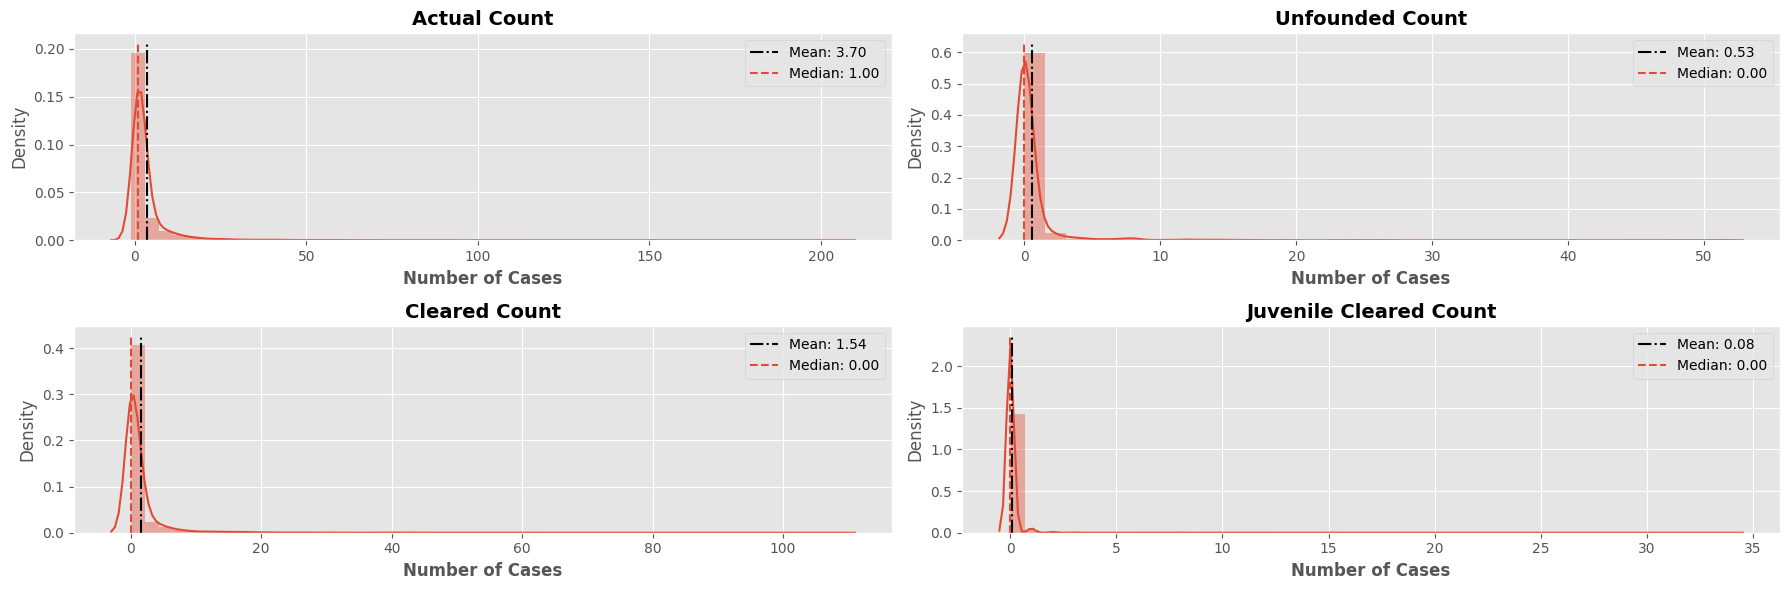

In [20]:
columns: List[str] = list(filter(lambda x: '_COUNT' in x, cde_df.columns.tolist()))
fig = plt.figure(figsize=(18,6)) 
for index,col in enumerate(columns, 1):

    ax = fig.add_subplot(2,2,index)
    curr_df: 'DataFrame' = cde_df[col] 
    sns.distplot(curr_df, ax=ax)
    ax.set_title(col.replace('_', ' ').title(), fontweight='bold', fontsize=14)
    ax.set_xlabel("Number of Cases", fontweight='bold')
    ymin,ymax = ax.get_ylim()

    mean: float = curr_df.mean() 
    median: float = curr_df.median()
    ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle="-.", color='black') 
    ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle="--") 
    ax.legend() 
plt.tight_layout()

## **Boxplot: Number of Offenses reported to the UCR Program by Region Name**

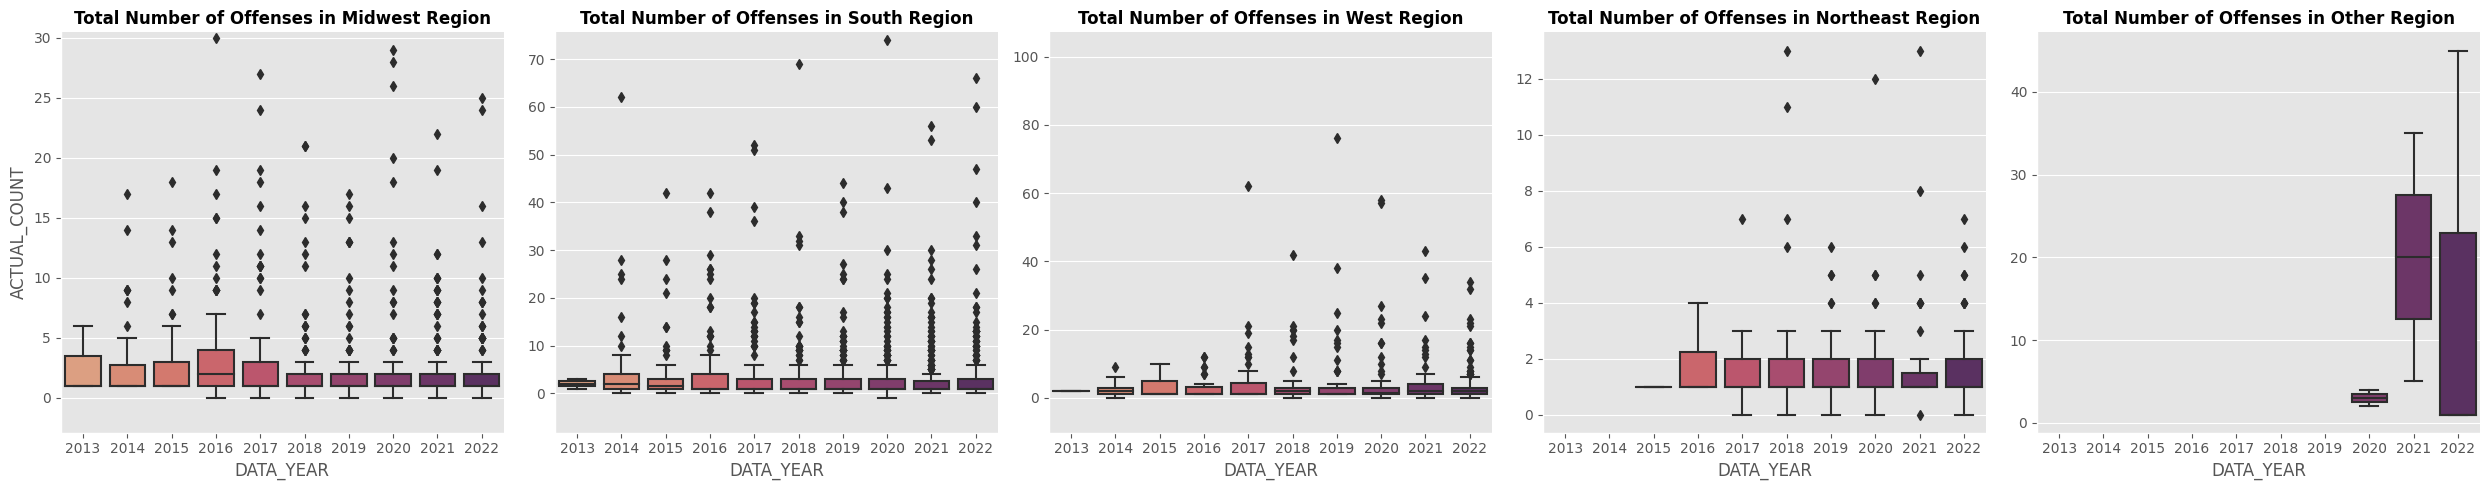

In [115]:
axs = sns.catplot(data=cde_df.query("REGION_NAME != 'U.S. Territories' "), col='REGION_NAME', x='DATA_YEAR', y='ACTUAL_COUNT', sharey=False, kind='box', palette='flare')
for index,ax in enumerate(axs.axes.ravel()):
    ymin,ymax = ax.get_ylim()
    ax.set_title( "Total Number of Offenses in %s Region" % (re.sub(".*.=", "", ax.get_title() ).strip() ) , fontweight='bold', fontsize=12)
    ax.set_ylim([ymin, ymax - (ymax * 0.5 ) if index < 3 else ymax ])

## **Total number of Human Trafficking reported to UCR Program** 

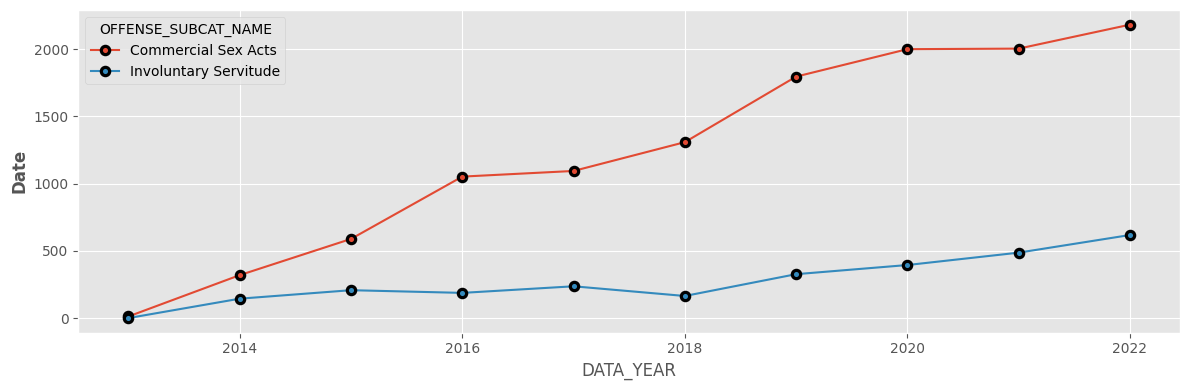

In [35]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
cde_df.groupby(['OFFENSE_SUBCAT_NAME', 'DATA_YEAR'])['ACTUAL_COUNT'].sum().unstack("OFFENSE_SUBCAT_NAME").plot(marker='o', mec='black', mew=2.3, ax=ax)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.set_ylabel("Date", fontweight='bold')
plt.tight_layout()

## **Total Number Reported Offenses by State**
- The graph below shows that Texas has the highest number of offenses reported to the UCR programs, followed by Nevada, Minnesota, Georgia, Florida, Wisconsin, Tennessee, and Colorado.


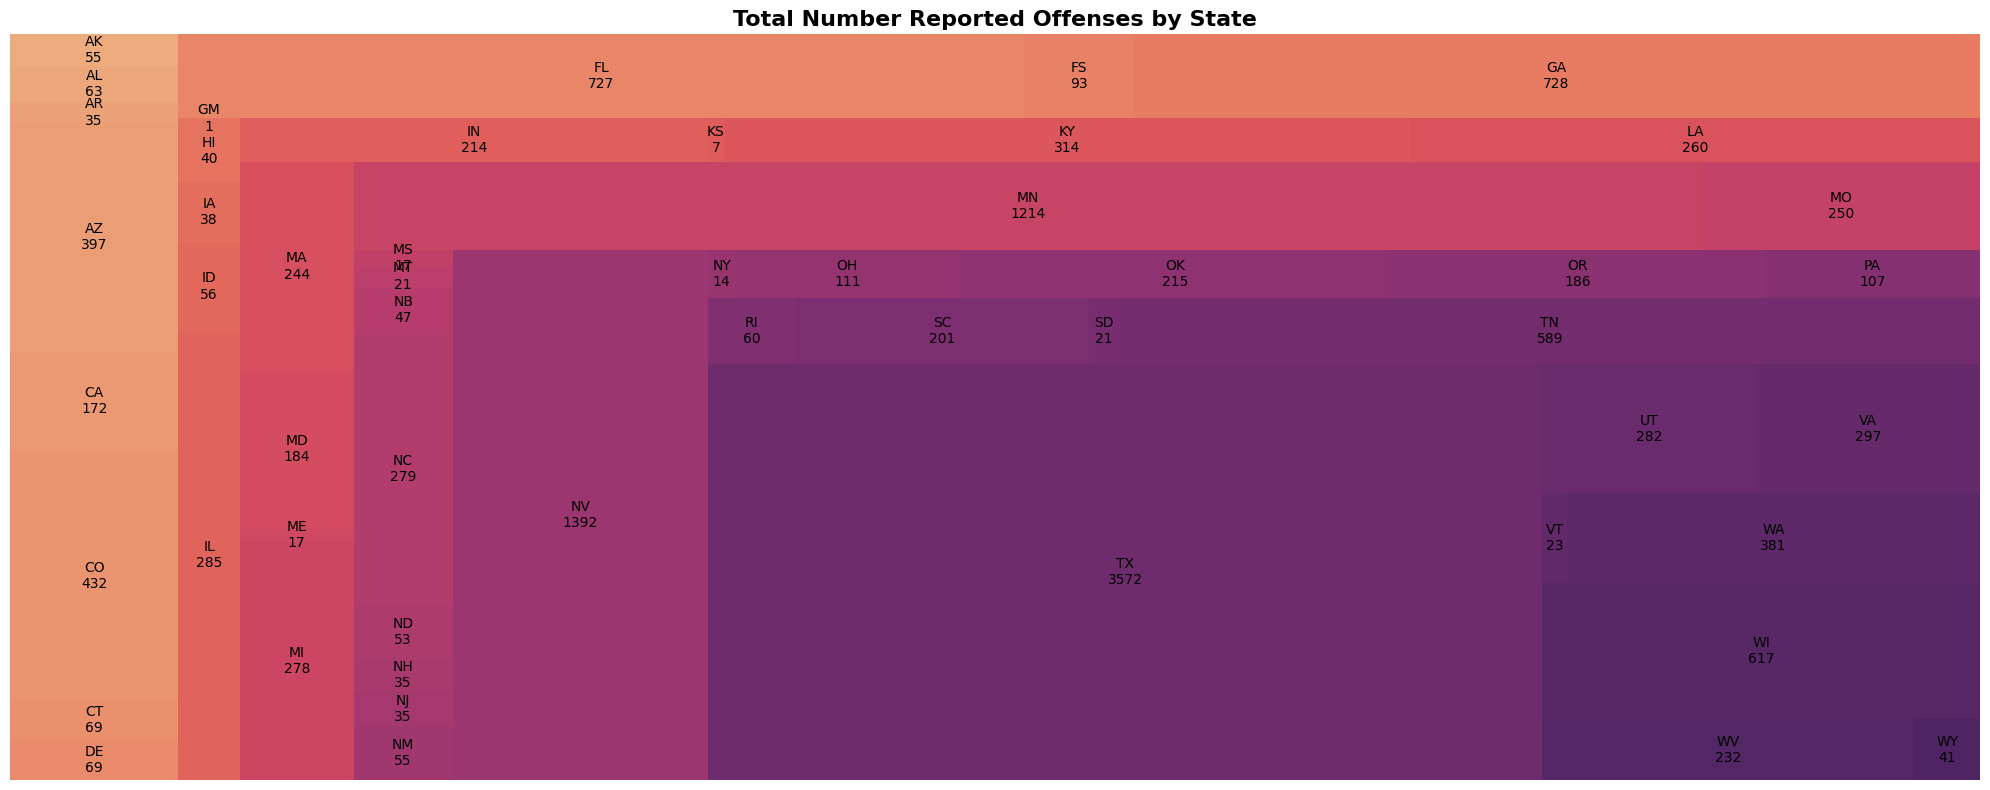

In [142]:
states, n_offenses = zip(*cde_df.groupby('STATE_ABBR')['ACTUAL_COUNT'].sum().to_dict().items())
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot() 

sq.plot(sizes=list(n_offenses), label=[ "%s\n%s" % (curr_state,n) for curr_state,n in zip(states, n_offenses) ], ax=ax, color=sns.color_palette(n_colors=52, palette='flare'))
ax.axis('off')
ax.set_title("Total Number Reported Offenses by State", fontweight='bold', fontsize=16)
ax.invert_yaxis()
plt.tight_layout()

## **Top 25 States: Total Number of Humman Trafficking Offenses**

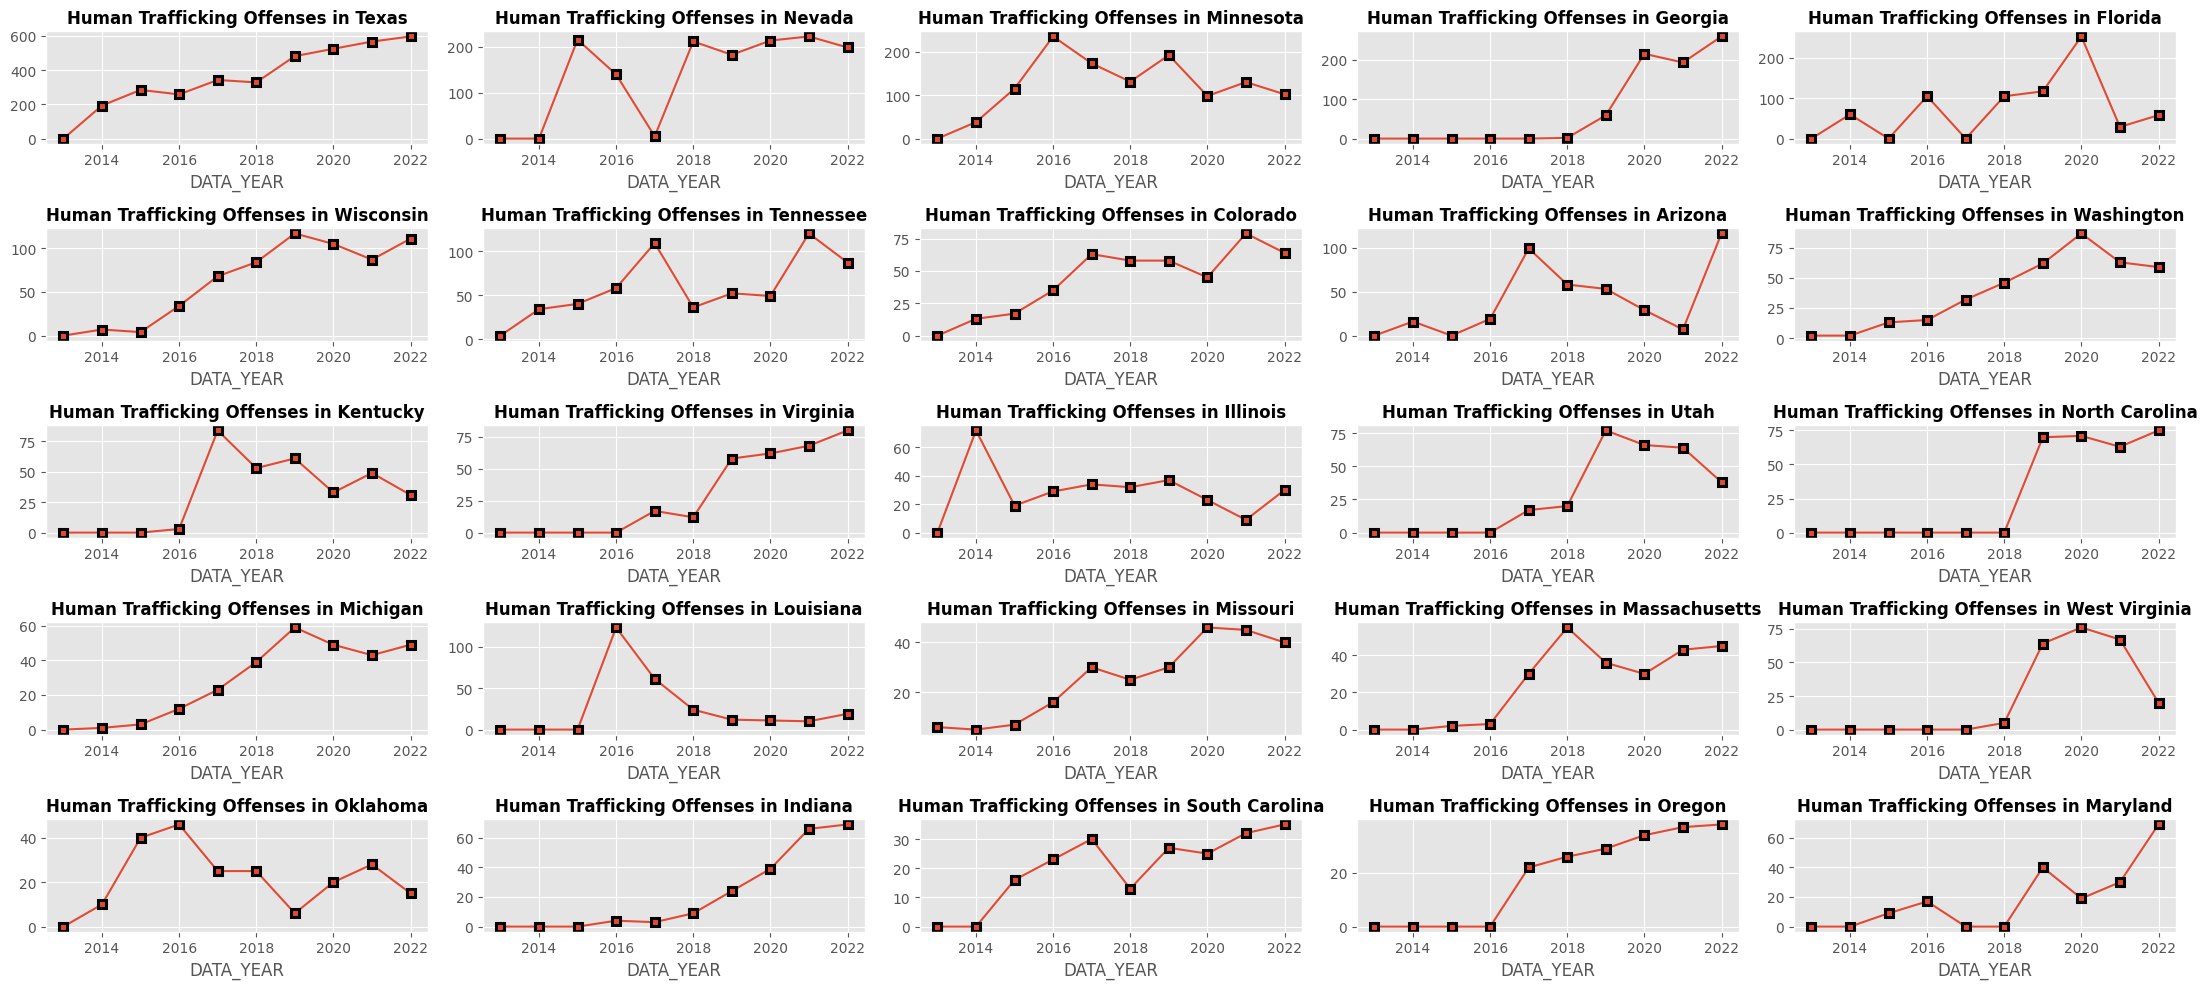

In [50]:
fig = plt.figure(figsize=(22,10)) 

ucr_program_summary: 'DataFrame' = pd.pivot_table(data=cde_df, columns='STATE_NAME', index='DATA_YEAR', values='ACTUAL_COUNT', aggfunc='sum').replace({np.nan:0.0})
for index, state in enumerate(ucr_program_summary.sum(axis=0).sort_values(ascending=False).head(25).index.tolist(),1):
    ax = fig.add_subplot(5,5,index)
    ucr_program_summary[state].plot(ax=ax, marker='s', mec='black', mew=2.2)
    ax.set_title("Human Trafficking Offenses in %s" % (state), fontweight='bold', fontsize=12)

plt.tight_layout()

## **Total Number of Human Trafficking Offenses reported to the UCR Program vs. Number of cases that were Cleared/Closed by US Region**

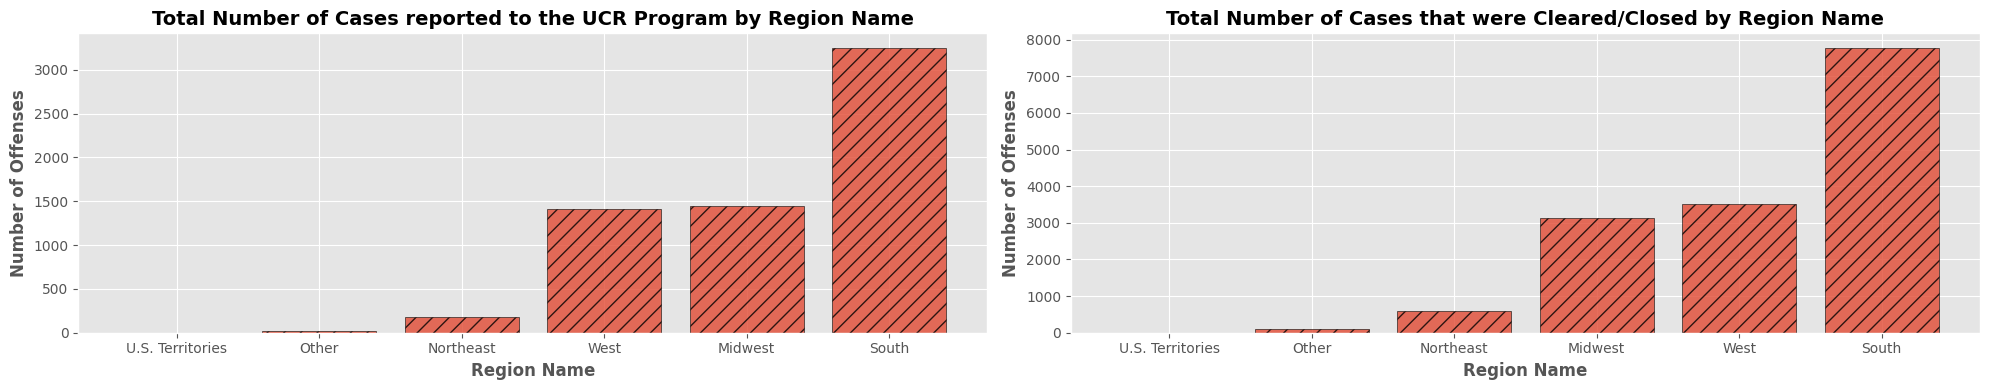

In [84]:
fig = plt.figure(figsize=(20,4))
region_names_one, total_cases_one = zip(*cde_df.groupby('REGION_NAME')['CLEARED_COUNT'].sum().sort_values().to_dict().items())
region_names_two, total_cases_two = zip(*cde_df.groupby('REGION_NAME')['ACTUAL_COUNT'].sum().sort_values().to_dict().items())

ax = fig.add_subplot(1,2,1)
ax.bar(x=list(region_names_one), height=list(total_cases_one), hatch='//', edgecolor='black', alpha=0.8)
ax.set_title("Total Number of Cases reported to the UCR Program by Region Name", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Offenses", fontweight='bold')
ax.set_xlabel("Region Name", fontweight='bold')

ax = fig.add_subplot(1,2,2)
ax.bar(x=list(region_names_two), height=list(total_cases_two), hatch='//', edgecolor='black', alpha=0.8)
ax.set_title("Total Number of Cases that were Cleared/Closed by Region Name", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Offenses", fontweight='bold')
ax.set_xlabel("Region Name", fontweight='bold')

plt.tight_layout()

## **Number of Offenses vs. Number of Cleared/Closed Cases by County,State**

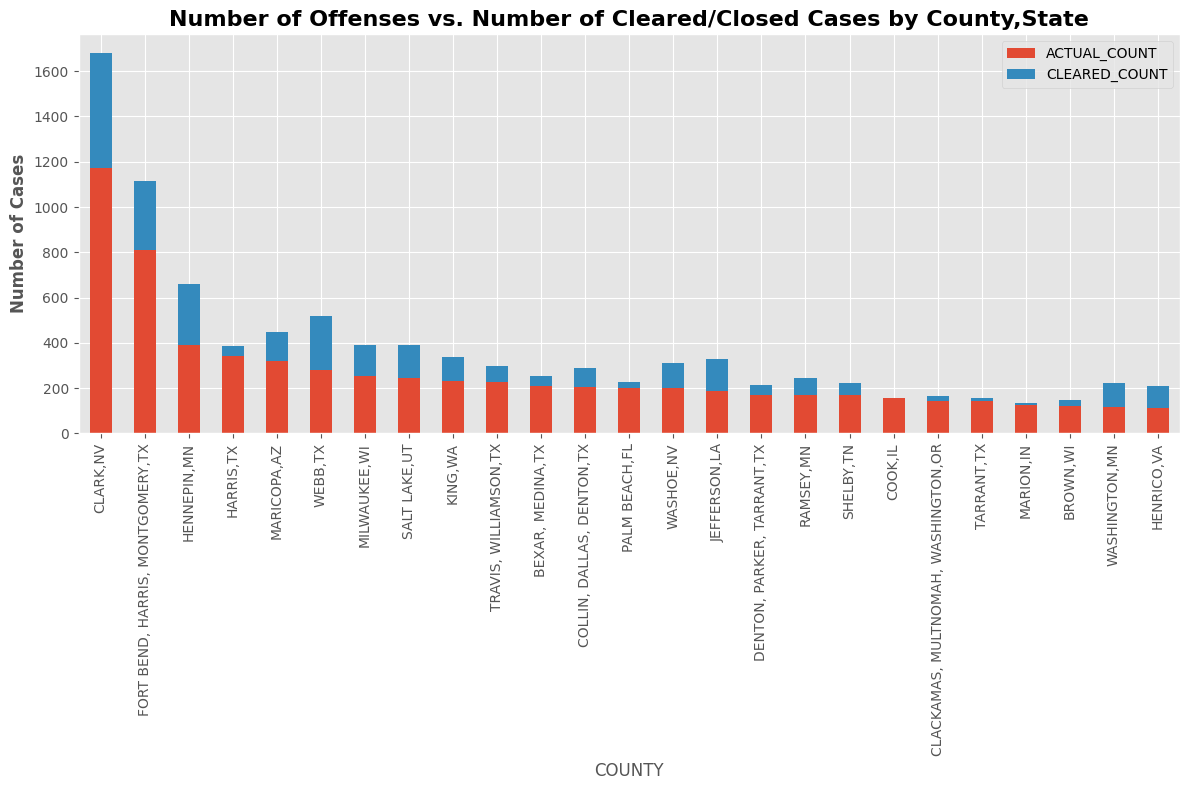

In [93]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
cde_df.groupby(['COUNTY'])[ ['ACTUAL_COUNT', 'CLEARED_COUNT'] ].sum().sort_values(['ACTUAL_COUNT', 'CLEARED_COUNT'] ,axis=0, ascending=False).head(25).plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.set_title("Number of Offenses vs. Number of Cleared/Closed Cases by County,State", fontweight='bold', fontsize=16)
plt.tight_layout()

# **Reported Crimes in Texas (NIBRS)** 

In [4]:
con: sqlite3 = sqlite3.connect("../datasets/Texas/texas.db")

## **Converting NIBRS Dataset into SQLite Format**

In [47]:
for item in os.listdir(dataset_path): 
    if 'csv' in item:
        print("[ \033[92m+\033[0m ] Converting %s -> %s" % (item, re.sub(r".csv", "", item).strip())  ) 
        pd.read_csv(os.path.join(dataset_path, item) ).to_sql(re.sub(r".csv", "", item).strip() , con=con, if_exists='append')

[ + ] Converting NIBRS_VICTIM.csv -> NIBRS_VICTIM
[ + ] Converting NIBRS_PROPERTY_DESC.csv -> NIBRS_PROPERTY_DESC
[ + ] Converting NIBRS_incident.csv -> NIBRS_incident
[ + ] Converting NIBRS_ARREST_TYPE.csv -> NIBRS_ARREST_TYPE
[ + ] Converting NIBRS_ARRESTEE_WEAPON.csv -> NIBRS_ARRESTEE_WEAPON
[ + ] Converting NIBRS_WEAPON_TYPE.csv -> NIBRS_WEAPON_TYPE
[ + ] Converting NIBRS_LOCATION_TYPE.csv -> NIBRS_LOCATION_TYPE
[ + ] Converting NIBRS_PROP_DESC_TYPE.csv -> NIBRS_PROP_DESC_TYPE
[ + ] Converting NIBRS_SUSPECTED_DRUG.csv -> NIBRS_SUSPECTED_DRUG
[ + ] Converting NIBRS_OFFENDER.csv -> NIBRS_OFFENDER
[ + ] Converting NIBRS_AGE.csv -> NIBRS_AGE
[ + ] Converting NIBRS_ETHNICITY.csv -> NIBRS_ETHNICITY
[ + ] Converting NIBRS_VICTIM_INJURY.csv -> NIBRS_VICTIM_INJURY
[ + ] Converting NIBRS_ASSIGNMENT_TYPE.csv -> NIBRS_ASSIGNMENT_TYPE
[ + ] Converting NIBRS_BIAS_MOTIVATION.csv -> NIBRS_BIAS_MOTIVATION
[ + ] Converting NIBRS_CRIMINAL_ACT_TYPE.csv -> NIBRS_CRIMINAL_ACT_TYPE
[ + ] Converting NIBRS

##  **NIBRS Tables**
- **Reported Years**: 2021, 2022 (Collected data before,during, and after Covid-19)

In [95]:
nibrs_tables: 'DataFrame' = pd.read_sql("SELECT name FROM sqlite_master WHERE type == 'table' " , con=con ) 
lookup_tbl: Dict = { tbl:pd.read_sql(f"SELECT * FROM {tbl} LIMIT 1", con=con).columns.tolist() for tbl in nibrs_tables['name'].tolist() }

nibrs_tables.sort_values(by='name', ascending=False)

name
41                      agencies
30                     REF_STATE
31                      REF_RACE
40                   NIBRS_month
2                 NIBRS_incident
5              NIBRS_WEAPON_TYPE
42                  NIBRS_WEAPON
33             NIBRS_VICTIM_TYPE
27          NIBRS_VICTIM_OFFENSE
32     NIBRS_VICTIM_OFFENDER_REL
12           NIBRS_VICTIM_INJURY
25    NIBRS_VICTIM_CIRCUMSTANCES
0                   NIBRS_VICTIM
19              NIBRS_USING_LIST
17           NIBRS_SUSPECT_USING
21     NIBRS_SUSPECTED_DRUG_TYPE
8           NIBRS_SUSPECTED_DRUG
22            NIBRS_RELATIONSHIP
35          NIBRS_PROP_LOSS_TYPE
7           NIBRS_PROP_DESC_TYPE
1            NIBRS_PROPERTY_DESC
24                NIBRS_PROPERTY
23            NIBRS_OFFENSE_TYPE
39                 NIBRS_OFFENSE
9                 NIBRS_OFFENDER
6            NIBRS_LOCATION_TYPE
18       NIBRS_JUSTIFIABLE_FORCE
29                  NIBRS_INJURY
11               NIBRS_ETHNICITY
43       NIBRS_DRUG_MEASURE_TYPE
16       NIBRS_CRIMINAL_ACT_TYPE
34            NIBRS_CRIMINAL_ACT
28          NIBRS_CLEARED_EXCEPT
20           NIBRS_CIRCUMSTANCES
15         NIBRS_BIAS_MOTIVATION
38               NIBRS_BIAS_LIST
14         NIBRS_ASSIGNMENT_TYPE
3              NIBRS_ARREST_TYPE
4          NIBRS_ARRESTEE_WEAPON
13  NIBRS_ARRESTEE_GROUPB_WEAPON
36         NIBRS_ARRESTEE_GROUPB
26                NIBRS_ARRESTEE
10                     NIBRS_AGE
37           NIBRS_ACTIVITY_TYPE

## **Query: Reported Crimes in Texas according to `NIBRS`**

In [4]:
query: str = """ 
SELECT 
    nv.data_year,
    nv.sex_code,
    ne.ethnicity_id, 
    ne.ethnicity_code AS `victim_ethnicity_code`, 
    ne.ethnicity_name AS `victim_ethnicity_name`,
    nwt.weapon_name, 
    nwt.weapon_code, 
    nwt.shr_flag, 
    no.num_premises_entered,
    no.method_entry_code,
    nat.activity_type_code,
    nat.activity_type_name, 
    nlt.location_name,
    ncat.criminal_act_id,
    ncat.criminal_act_name, 
    ncat.criminal_act_desc,
    ncat.criminal_act_code, 
    nsd.est_drug_qty, 
    nsd.drug_measure_type_id, 
    nsd.nibrs_suspected_drug_id, 
    nbl.bias_code,
    nbl.bias_category,
    nbl.bias_desc,
    nvt.victim_type_code,
    nvt.victim_type_name,
    na.arrestee_seq_num,
    na.arrest_date,
    na.arrest_type_id,
    na.multiple_indicator,
    na.offense_code,
    na.age_id,
    na.age_num,
    na.sex_code,
    na.race_id,
    na.ethnicity_id,
    na.resident_code,
    na.under_18_disposition_code,
    na.clearance_ind,
    na.age_range_low_num,
    na.age_range_high_num, 
    ni.cargo_theft_flag,
    ni.submission_date,
    ni.incident_date,
    ni.report_date_flag,
    ni.incident_hour,
    ni.cleared_except_id,
    ni.cleared_except_date,
    ni.incident_status,
    ni.data_home,
    ni.orig_format, 
    a.*  -- all agency attributes
    
FROM NIBRS_VICTIM nv 
JOIN NIBRS_VICTIM_INJURY nvi ON nvi.victim_id = nv.victim_id 
JOIN NIBRS_ETHNICITY ne ON ne.ethnicity_id = nv.ethnicity_id 
JOIN NIBRS_OFFENSE no ON no.incident_id = nv.incident_id
JOIN NIBRS_WEAPON nw ON nw.offense_id = no.offense_id
JOIN NIBRS_WEAPON_TYPE nwt ON nwt.weapon_id = nw.weapon_id
JOIN NIBRS_ACTIVITY_TYPE nat ON nat.activity_type_id = nv.activity_type_id
JOIN NIBRS_LOCATION_TYPE nlt ON nlt.location_id = no.location_id
JOIN NIBRS_CRIMINAL_ACT nca ON nca.offense_id = no.offense_id
JOIN NIBRS_CRIMINAL_ACT_TYPE ncat ON ncat.criminal_act_id = nca.criminal_act_id
JOIN NIBRS_PROPERTY np ON np.incident_id = nv.incident_id AND nv.data_year = np.data_year
JOIN NIBRS_SUSPECTED_DRUG nsd ON nsd.property_id = np.property_id AND nsd.data_year = np.data_year
JOIN NIBRS_DRUG_MEASURE_TYPE ndmt ON ndmt.drug_measure_type_id = nsd.drug_measure_type_id
JOIN NIBRS_BIAS_MOTIVATION nbm ON nbm.offense_id = no.offense_id AND nbm.data_year = no.data_year
JOIN NIBRS_BIAS_LIST nbl ON nbl.bias_id = nbm.bias_id
JOIN NIBRS_VICTIM_TYPE nvt ON nvt.victim_type_id = nv.victim_type_id
JOIN NIBRS_ARRESTEE na ON na.incident_id = nv.incident_id AND na.data_year = nv.data_year
JOIN NIBRS_incident ni ON ni.incident_id = no.incident_id
JOIN agencies a ON a.agency_id = ni.agency_id
"""
crimes_df: 'DataFrame' = pd.read_sql(query, con=con)
crimes_df = crimes_df.drop_duplicates() 
crimes_df['arrest_date'] = pd.to_datetime(crimes_df['arrest_date'])
crimes_df['month_name'] = crimes_df['arrest_date'].apply(lambda row: row.month_name() )
crimes_df['month'] = crimes_df['arrest_date'].apply(lambda row: row.month )
crimes_df['incident_date'] = pd.to_datetime( crimes_df['incident_date'])
crimes_df.index = np.arange(1, crimes_df.shape[0] + 1 )
crimes_df.head()

data_year sex_code  ethnicity_id victim_ethnicity_code  \
1       2022        M            20                     N   
2       2022        M            20                     N   
3       2022        M            20                     N   
4       2022        M            20                     N   
5       2022        M            20                     N   

    victim_ethnicity_name weapon_name weapon_code shr_flag  \
1  Not Hispanic or Latino     Handgun          12        t   
2  Not Hispanic or Latino     Handgun          12        t   
3  Not Hispanic or Latino     Handgun          12        t   
4  Not Hispanic or Latino     Handgun          12        t   
5  Not Hispanic or Latino     Handgun          12        t   

  num_premises_entered method_entry_code  activity_type_code  \
1                 None              None                  10   
2                 None              None                  10   
3                 None              None                  10   
4                 None              None                  10   
5                 None              None                   6   

                             activity_type_name  \
1                    Traffic Pursuits and Stops   
2                    Traffic Pursuits and Stops   
3                    Traffic Pursuits and Stops   
4                    Traffic Pursuits and Stops   
5  Handling, Transporting, Custody of Prisoners   

                        location_name  criminal_act_id      criminal_act_name  \
1  Highway/Road/Alley/Street/Sidewalk                6  Possessing/Concealing   
2  Highway/Road/Alley/Street/Sidewalk                6  Possessing/Concealing   
3  Highway/Road/Alley/Street/Sidewalk                6  Possessing/Concealing   
4  Highway/Road/Alley/Street/Sidewalk                6  Possessing/Concealing   
5                    Hotel/Motel/Etc.                6  Possessing/Concealing   

       criminal_act_desc criminal_act_code  est_drug_qty  \
1  Possessing/Concealing                 P          0.06   
2  Possessing/Concealing                 P          0.06   
3  Possessing/Concealing                 P          0.06   
4  Possessing/Concealing                 P          0.06   
5  Possessing/Concealing                 P          0.30   

   drug_measure_type_id  nibrs_suspected_drug_id  bias_code bias_category  \
1                     3                 14378518         88  None/Unknown   
2                     3                 14378518         88  None/Unknown   
3                     3                 14378518         88  None/Unknown   
4                     3                 14378518         88  None/Unknown   
5                     1                 14571178         88  None/Unknown   

        bias_desc victim_type_code         victim_type_name  arrestee_seq_num  \
1  None (no bias)                L  Law Enforcement Officer                 1   
2  None (no bias)                L  Law Enforcement Officer                 1   
3  None (no bias)                L  Law Enforcement Officer                 2   
4  None (no bias)                L  Law Enforcement Officer                 2   
5  None (no bias)                L  Law Enforcement Officer                 1   

  arrest_date  arrest_type_id multiple_indicator offense_code  age_id  \
1  2022-06-20               1                  N          520      23   
2  2022-06-20               1                  N          520      23   
3  2022-06-20               1                  N          520      21   
4  2022-06-20               1                  N          520      21   
5  2022-12-15               1                  N          13B      54   

   age_num sex_code  race_id  ethnicity_id resident_code  \
1       20        M       20            20          None   
2       20        M       20            20          None   
3       18        M       20            20          None   
4       18        M       20            20          None   
5       51        M       20      

## **Distribution of the Arrestee Age** 

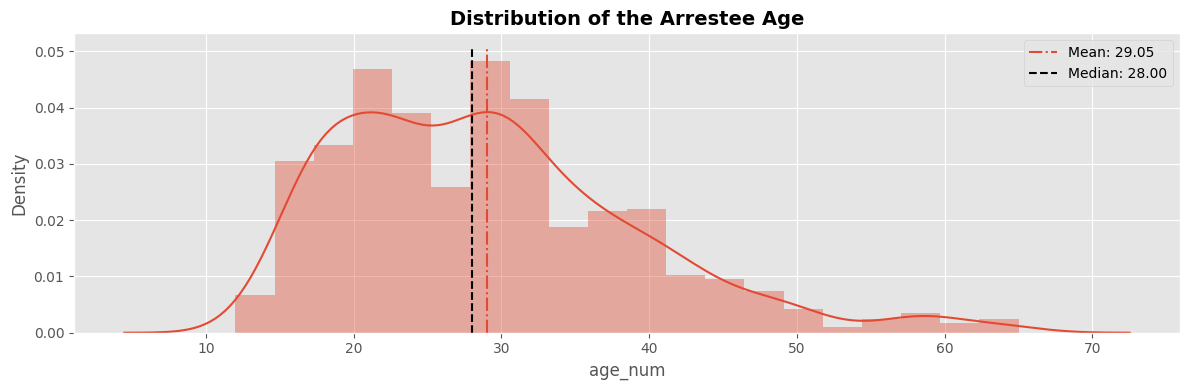

In [168]:
fig = plt.figure(figsize=(12,4) )
ax = fig.add_subplot() 
sns.distplot( crimes_df['age_num'],ax=ax )
ax.set_title("Distribution of the Arrestee Age",fontweight='bold', fontsize=14)
ymin,ymax = ax.get_ylim() 

mean: float = crimes_df['age_num'].mean()
median: float = crimes_df['age_num'].median() 

ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle='-.')
ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle='--', color='black' )
ax.legend() 
plt.tight_layout() 

## **Trends in Arrest Made**

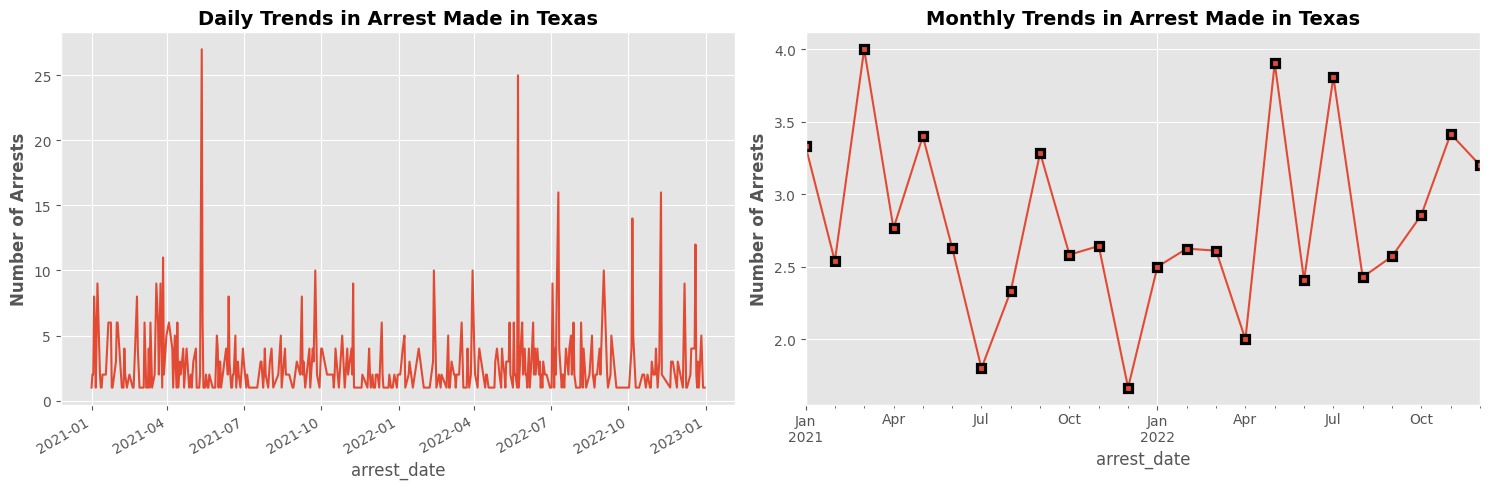

In [162]:
fig = plt.figure(figsize=(15,5)) 
ax = fig.add_subplot(1,2,1)
crimes_df.groupby('arrest_date').size().sort_index().plot(ax=ax) 
ax.set_title("Daily Trends in Arrest Made in Texas", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Arrests", fontweight='bold')

ax = fig.add_subplot(1,2,2)
crimes_df.groupby('arrest_date').size().sort_index().resample('M').mean().plot(ax=ax, marker='s', mec='black', mew=2.3,) 
ax.set_title("Monthly Trends in Arrest Made in Texas", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Arrests", fontweight='bold')

plt.tight_layout() # incident date, number of arrest based on activity_type_name

## **Trends in Criminal Activities in `TX`**

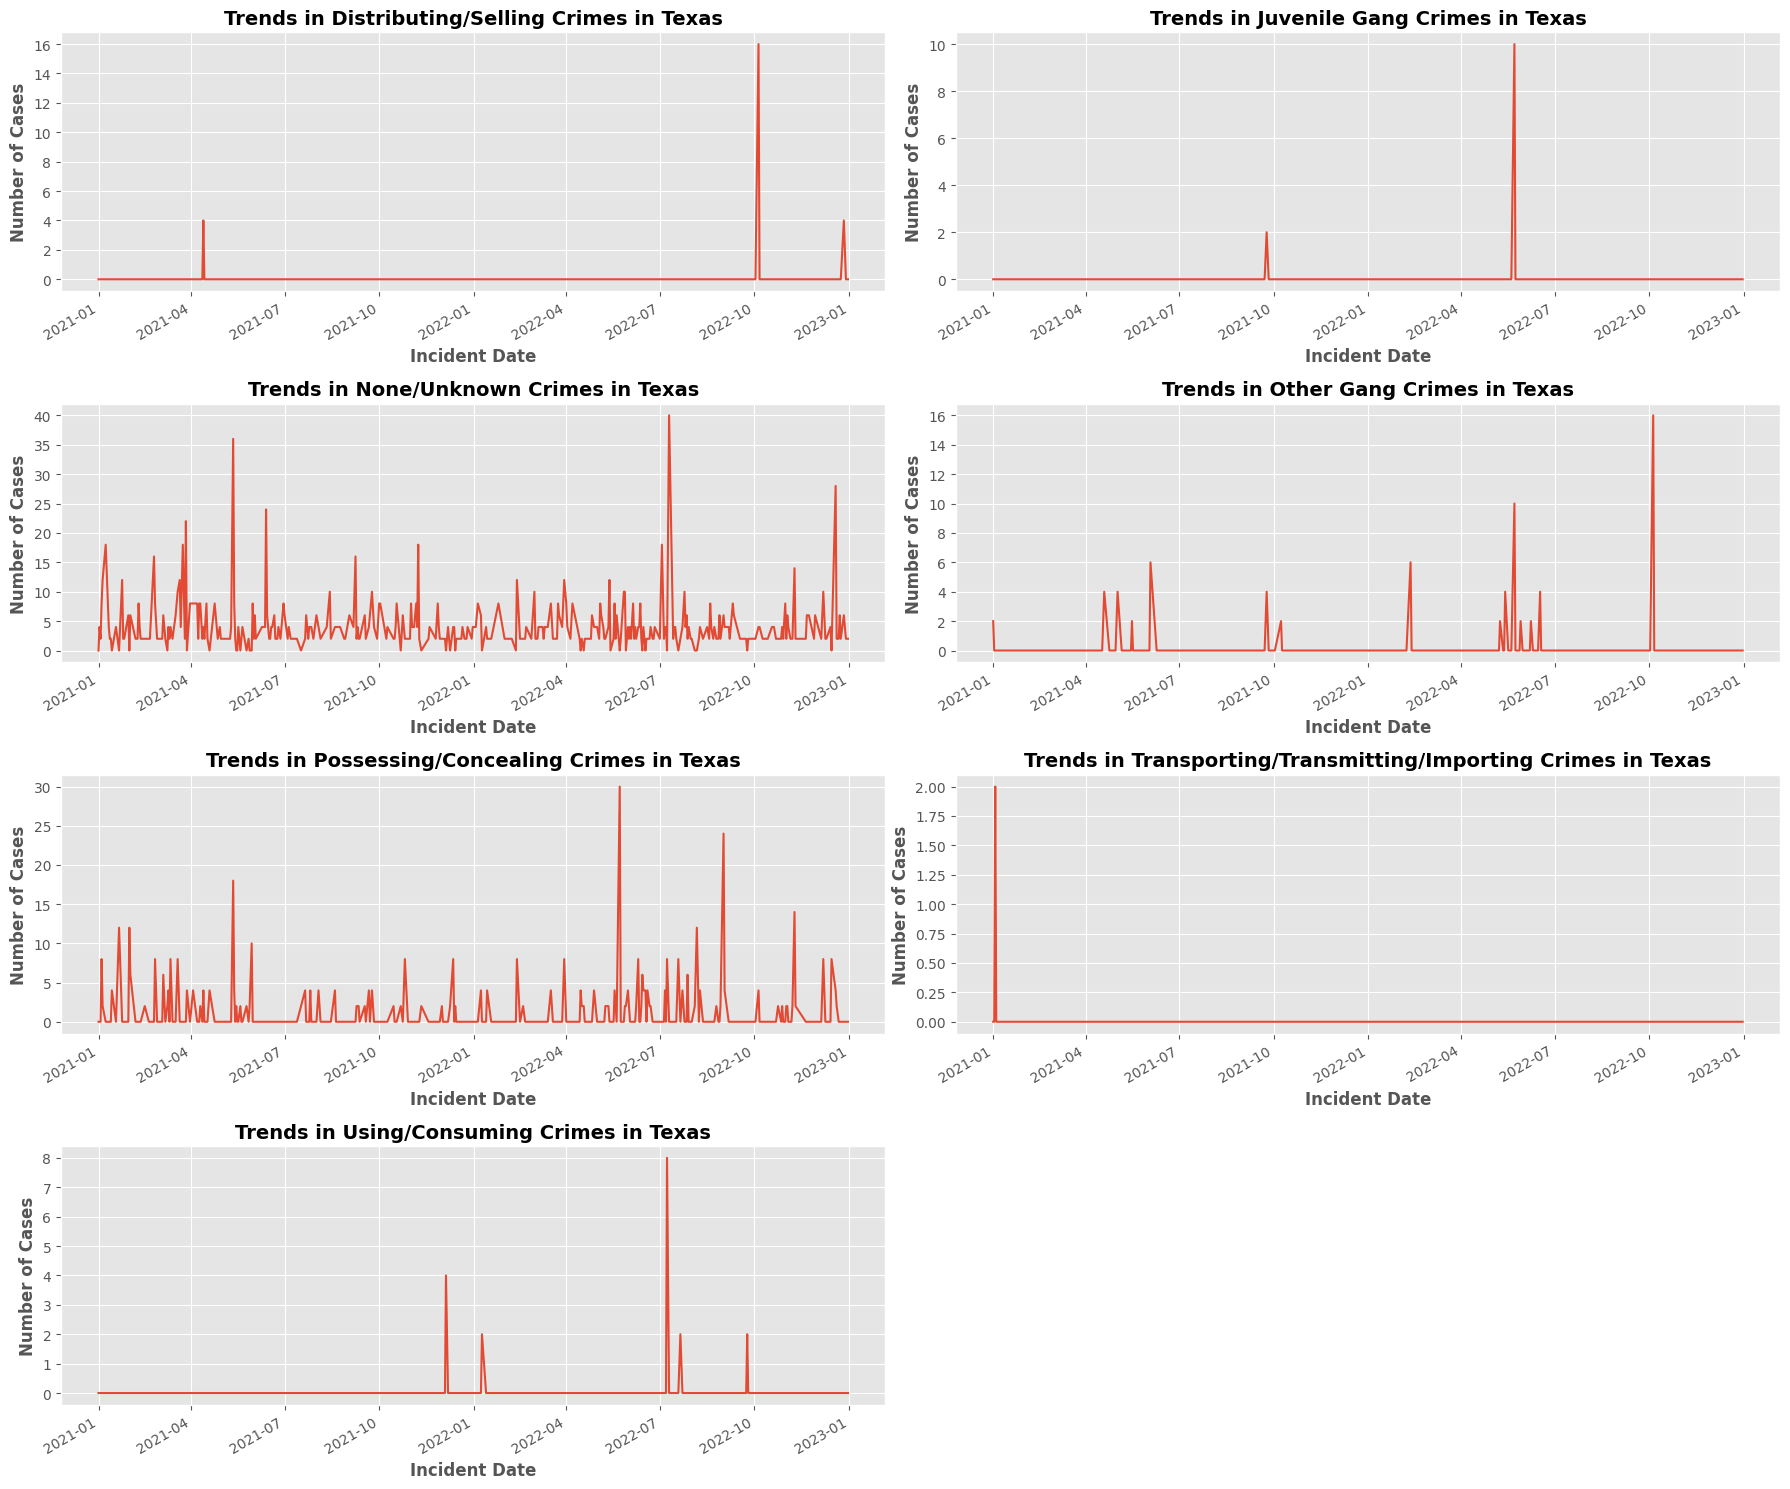

In [58]:
fig = plt.figure(figsize=(18,15))

crime_trends: 'DataFrame' = crimes_df.groupby(['incident_date','criminal_act_name']).size().unstack('criminal_act_name').replace({np.nan:0.0})
for index,crime_type in enumerate(crimes_df['criminal_act_name'].sort_values().unique().tolist(),1): 
    ax = fig.add_subplot(4,2,index)
    crime_trends[crime_type].plot(ax=ax)
    ax.set_title(f"Trends in %s Crimes in Texas" % (crime_type.title()), fontweight='bold', fontsize=14 )
    ax.set_ylabel("Number of Cases", fontweight='bold')
    ax.set_xlabel("Incident Date", fontweight='bold')

plt.tight_layout() 

## **Types of Crimes and Weapons used During the Incident** 

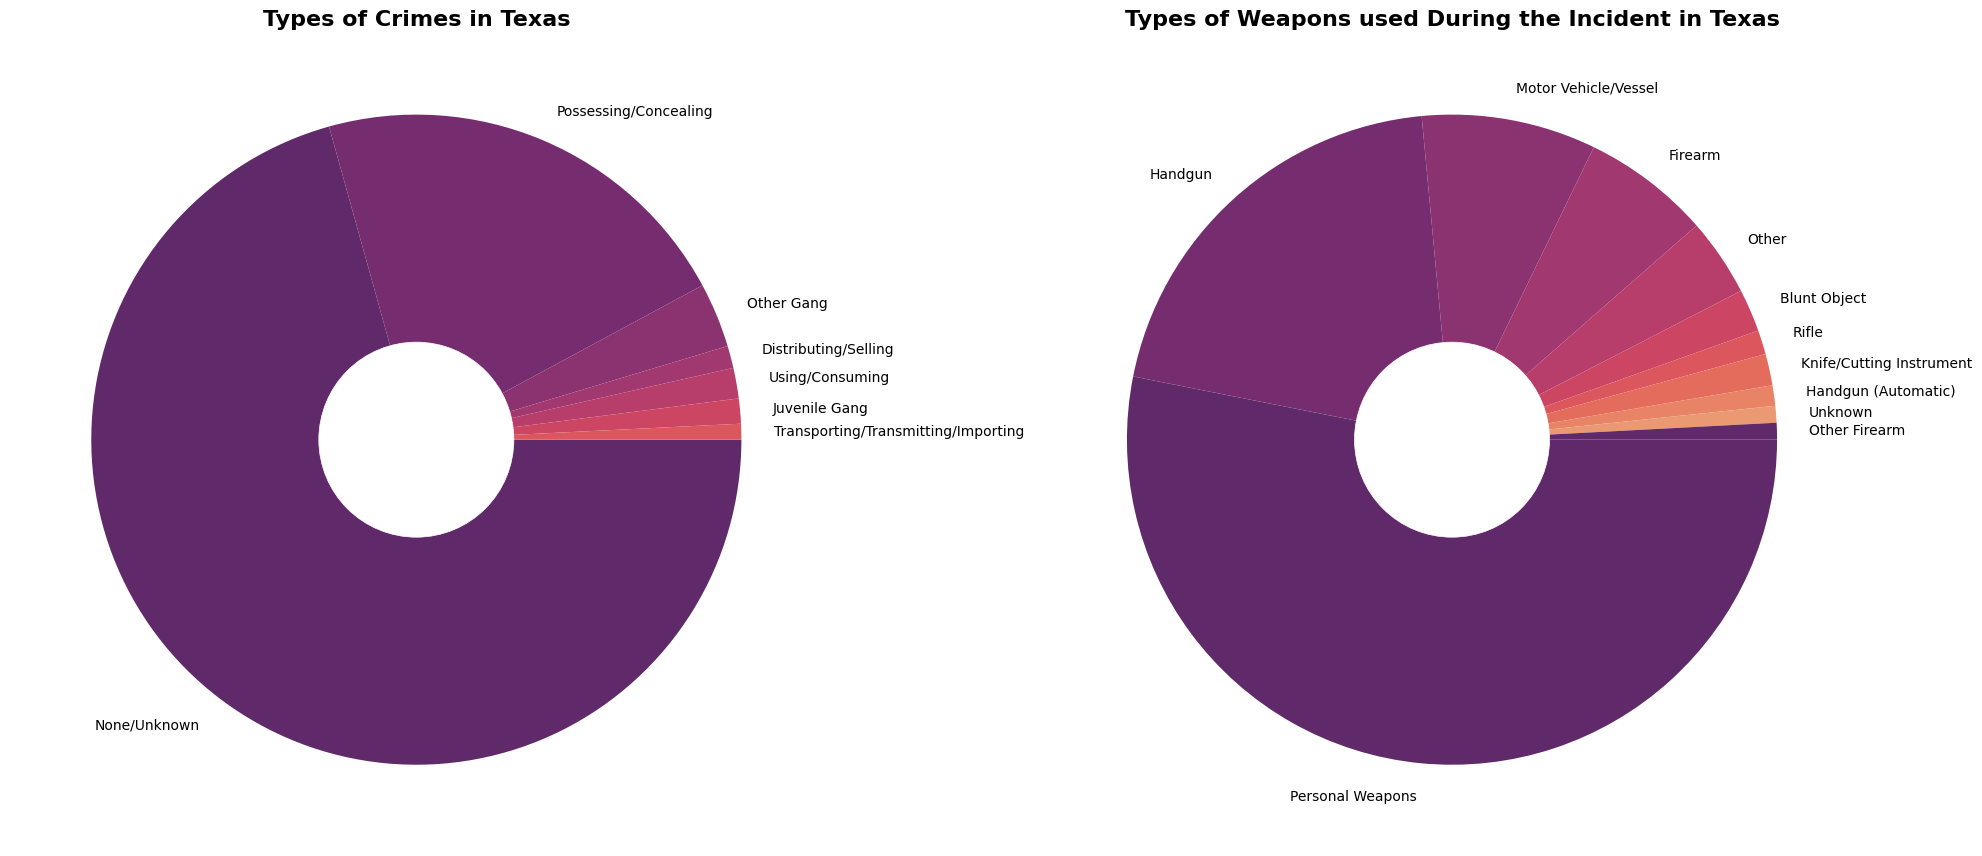

In [109]:
crime_names, freqs = zip(*crimes_df['criminal_act_name'].value_counts().to_dict().items()) 
weapons_types, weap_freqs = zip(*crimes_df['weapon_name'].value_counts().to_dict().items())

fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(1,2,1)
ax.set_title("Types of Crimes in Texas", fontweight='bold', fontsize=16 )
ax.pie(x=list( freqs[:4] ) + (np.array(freqs[4:]) + 15 ).tolist() , labels=list(crime_names), colors=sns.color_palette(n_colors=10, palette='flare_r'), counterclock=False, rotatelabels=False)
plt.gcf().gca().add_artist(plt.Circle((0,0), radius=0.3, color='white' ) )

ax = fig.add_subplot(1,2,2)
ax.set_title("Types of Weapons used During the Incident in Texas", fontweight='bold', fontsize=16 )
ax.pie(x=list(weap_freqs[:-4] ) + (np.array(weap_freqs[-4:] ) + 10 ).tolist() , labels=list(weapons_types), colors=sns.color_palette(n_colors=10, palette='flare_r'), counterclock=False, rotatelabels=False)
plt.gcf().gca().add_artist(plt.Circle((0,0), radius=0.3, color='white' ) )
plt.tight_layout() 


In [62]:
# incident_date, activity_type_name,  weapon_name
# TODO: Unknown Crimes? and weaps used during the incident

## **Assaults on Law Enforcement Officers**
- Build Assults Events History DB
- Explore Methods 

In [58]:
con2: 'SQLite' = sqlite3.connect("../datasets/leoka_assignment_activities.db")
for csv_file in os.listdir("../datasets/"):
    if 'LEOKA_ASSIGNMENT_ACTIVITY' in csv_file: 
        print(f"[ \033[92m+\033[0m ] Converting {csv_file} to sqlite3 ...")
        pd.read_csv(os.path.join("../datasets", csv_file ) ).to_sql("LEOKA_ASSIGNMENT_ACTIVITY", con=con2, if_exists='append')

con3: 'SQLite' = sqlite3.connect("../datasets/assault_time_weapon_injury.db")
_ = pd.read_csv("../datasets/LEOKA_ASSAULT_TIME_WEAPON_INJURY_1995_2022.csv").to_sql("LEOKA_ASSAULT_TIME_WEAPON_INJURY_1995_2022", con=con3, if_exists='append')

[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2020_2022.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2015_2019.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2010_2014.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2005_2009.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_2000_2004.csv to sqlite3 ...
[ + ] Converting LEOKA_ASSIGNMENT_ACTIVITY_1995_1999.csv to sqlite3 ...


## **Information about LEOKA - Assignment and activity data**

In [3]:
con2: 'SQLite' = sqlite3.connect("../datasets/leoka_assignment_activities.db")
query: str = """
SELECT 
    laa.data_year,
    laa.pub_agency_name,
    laa.pub_agency_unit,
    laa.state_abbr,
    laa.division_name,
    laa.region_name,
    laa.agency_type_name,
    laa.population_group_desc,
    laa.county_name,
    laa.activity_id,
    laa.activity_name,
    laa.two_officer_vehicle_actual,
    laa.one_officer_alone_actual,
    laa.one_officer_assisted_actual,
    laa.det_spe_ass_alone_actual,
    laa.det_spe_ass_assisted_actual,
    laa.other_alone_actual,
    laa.other_assisted_actual,
    laa.firearm_actual,
    laa.knife_actual,
    laa.hands_fists_feet_actual,
    laa.other_actual,
    laa.cleared_count
FROM LEOKA_ASSIGNMENT_ACTIVITY laa
"""
leoka_df: 'DataFrame' = pd.read_sql(query, con=con2)
leoka_df['STATE'] = leoka_df['STATE_ABBR'].apply(lambda row: states_lookup.get(row))

## **Information about LEOKA - Time of incident, weapon, and injury data**

In [186]:
con3: 'SQLite' = sqlite3.connect("../datasets/assault_time_weapon_injury.db")
query: str = """
SELECT 
    latwi.DATA_YEAR,
    latwi.PUB_AGENCY_NAME,
    latwi.PUB_AGENCY_UNIT,
    latwi.STATE_ABBR,
    latwi.DIVISION_NAME,
    latwi.REGION_NAME,
    latwi.AGENCY_TYPE_NAME,
    latwi.POPULATION_GROUP_DESC,
    latwi.COUNTY_NAME,
    latwi.TIME_0001_0200_CNT,
    latwi.TIME_0201_0400_CNT,
    latwi.TIME_0401_0600_CNT,
    latwi.TIME_0601_0800_CNT,
    latwi.TIME_0801_1000_CNT,
    latwi.TIME_1001_1200_CNT,
    latwi.TIME_1201_1400_CNT,
    latwi.TIME_1401_1600_CNT,
    latwi.TIME_1601_1800_CNT,
    latwi.TIME_1801_2000_CNT,
    latwi.TIME_2001_2200_CNT,
    latwi.TIME_2201_0000_CNT,
    latwi.FIREARM_INJURY_CNT,
    latwi.FIREARM_NO_INJURY_CNT,
    latwi.KNIFE_INJURY_CNT,
    latwi.KNIFE_NO_INJURY_CNT,
    latwi.HANDS_FISTS_FEET_INJURY_CNT,
    latwi.HANDS_FISTS_FEET_NO_INJURY_CNT,
    latwi.OTHER_INJURY_CNT,
    latwi.OTHER_NO_INJURY_CNT,
    latwi.LEOKA_FELONY_KILLED,
    latwi.LEOKA_ACCIDENT_KILLED

FROM LEOKA_ASSAULT_TIME_WEAPON_INJURY_1995_2022 latwi 

"""
assult_events: 'DataFrame' = pd.read_sql(query, con=con3)
assult_events['STATE'] = assult_events['STATE_ABBR'].apply(lambda row: states_lookup.get(row))
assult_events.head()

DATA_YEAR PUB_AGENCY_NAME PUB_AGENCY_UNIT STATE_ABBR   DIVISION_NAME  \
0       1995       Abbeville            None         GA  South Atlantic   
1       1995       Abbeville            None         SC  South Atlantic   
2       1995       Abbeville            None         SC  South Atlantic   
3       1995        Aberdeen            None         ID        Mountain   
4       1995        Aberdeen            None         MD  South Atlantic   

  REGION_NAME AGENCY_TYPE_NAME                     POPULATION_GROUP_DESC  \
0       South             City                        Cities under 2,500   
1       South             City              Cities from 2,500 thru 9,999   
2       South           County  Non-MSA counties from 10,000 thru 24,999   
3        West             City                        Cities under 2,500   
4       South             City            Cities from 10,000 thru 24,999   

  COUNTY_NAME  TIME_0001_0200_CNT  TIME_0201_0400_CNT  TIME_0401_0600_CNT  \
0      WILCOX                   0                   0                   0   
1   ABBEVILLE                   1                   0                   0   
2   ABBEVILLE                   0                   0                   0   
3     BINGHAM                   0                   0                   0   
4     HARFORD                   5                   2                   2   

   TIME_0601_0800_CNT  TIME_0801_1000_CNT  TIME_1001_1200_CNT  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   1                   0   
4                   0                   2                   1   

   TIME_1201_1400_CNT  TIME_1401_1600_CNT  TIME_1601_1800_CNT  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   3                   0                   1   

   TIME_1801_2000_CNT  TIME_2001_2200_CNT  TIME_2201_0000_CNT  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   2   
4                   3                   2                   8   

   FIREARM_INJURY_CNT  FIREARM_NO_INJURY_CNT  KNIFE_INJURY_CNT  \
0                   0                      0                 0   
1                   0                      0                 0   
2                   0                      0                 0   
3                   0                      0                 1   
4                   0                      0                 0   

   KNIFE_NO_INJURY_CNT  HANDS_FISTS_FEET_INJURY_CNT  \
0                    0                            0   
1                    0                            1   
2                    0                            0   
3                    0                            0   
4                    1                            3   

   HANDS_FISTS_FEET_NO_INJURY_CNT  OTHER_INJURY_CNT  OTHER_NO_INJURY_CNT  \
0                               0                 0                    0   
1                               0                 0                    0   
2                               0                 0                    0   
3                               2                 0                    0   
4                              23                 0                    2   

   LEOKA_FELONY_KILLED  LEOKA_ACCIDENT_KILLED           STATE  
0                    0                      0         Georgia  
1                    0                      0  South Carolina  
2                    0                      0  South Carolina  
3                 

## **Assaults on Law Enforcement Officers Numeric Variables Descriptions**

In [57]:
assult_events[ assult_events.dtypes.astype(str).apply(lambda row: 'int64' == row ).replace({False:np.nan}).dropna().index.tolist() ].describe()

DATA_YEAR  TIME_0001_0200_CNT  TIME_0201_0400_CNT  \
count  648312.000000       648312.000000       648312.000000   
mean     2008.287133            0.714505            0.444126   
std         7.575040            4.964472            3.304139   
min      1995.000000            0.000000            0.000000   
25%      2002.000000            0.000000            0.000000   
50%      2008.000000            0.000000            0.000000   
75%      2014.000000            0.000000            0.000000   
max      2022.000000          570.000000          294.000000   

       TIME_0401_0600_CNT  TIME_0601_0800_CNT  TIME_0801_1000_CNT  \
count       648312.000000       648312.000000       648312.000000   
mean             0.179247            0.134266            0.217636   
std              1.461448            1.041871            1.583881   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max            178.000000           95.000000          150.000000   

       TIME_1001_1200_CNT  TIME_1201_1400_CNT  TIME_1401_1600_CNT  \
count       648312.000000       648312.000000       648312.000000   
mean             0.279316            0.315290            0.385049   
std              2.044333            2.234271            2.695274   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max            201.000000          282.000000          298.000000   

       TIME_1601_1800_CNT  TIME_1801_2000_CNT  TIME_2001_2200_CNT  \
count       648312.000000       648312.000000       648312.000000   
mean             0.463811            0.538907            0.633772   
std              3.344341            3.813137            4.270711   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max            331.000000          406.000000          381.000000   

       TIME_2201_0000_CNT  FIREARM_INJURY_CNT  FIREARM_NO_INJURY_CNT  \
count       648312.000000       648312.000000          648312.000000   
mean             0.676168            0.022850               0.171772   
std              4.493861            0.720406               1.978902   
min              0.000000            0.000000               0.000000   
25%              0.000000            0.000000               0.000000   
50%              0.000000            0.000000               0.000000   
75%              0.000000            0.000000               0.000000   
max            450.000000          249.000000             276.000000   

       KNIFE_INJURY_CNT  KNIFE_NO_INJURY_CNT  HANDS_FISTS_FEET_INJURY_CNT  \
count     648312.000000        648312.000000                648312.000000   
mean           0.014657             0.078126                     1.216078   
std            0.277619             0.682927                     9.806935   
min            0.000000             0.000000                     0.000000   
25%            0.000000             0.000000                     0.000000   
50%            0.000000             0.000000                     0.000000   
75%            0.000000             0.000000                     0.000000   
max           79.000000            68.000000                  2297.000000   

       HANDS_FISTS_FEET_NO_INJURY_CNT  OTHER_INJURY_CNT  OTHER_NO_INJURY_CNT  \
count                   648312.000000     648312.000000        648312.000000   
mean                         2.774716          0.187098          

## **Number of Assaults on Law Enforcement Officers in the South Region** 

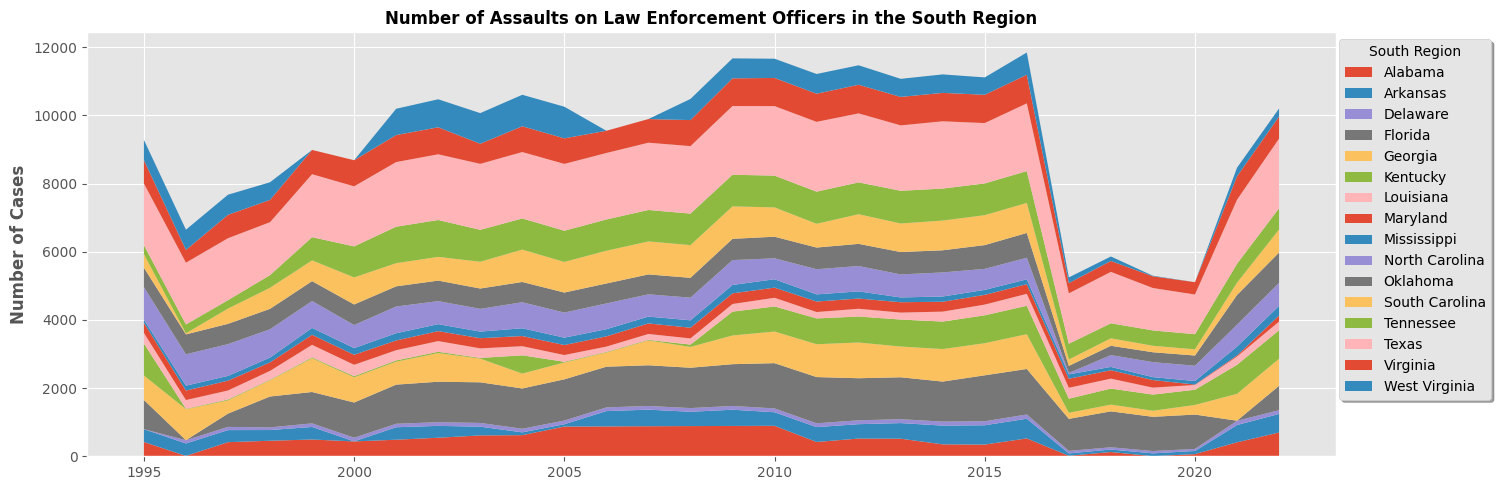

In [39]:
south_region: 'DataFrame' = assult_events.query("REGION_NAME == 'South'").groupby(['DATA_YEAR','STATE']).size().unstack('DATA_YEAR').replace({np.nan:0.0}).transpose()
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() 
ax.stackplot(south_region.index.tolist(), 
            south_region['Alabama'].tolist(),
            south_region['Arkansas'].tolist(),
            south_region['Delaware'].tolist(),
            south_region['Florida'].tolist(),
            south_region['Georgia'].tolist(),
            south_region['Kentucky'].tolist(),
            south_region['Louisiana'].tolist(),
            south_region['Maryland'].tolist(),
            south_region['Mississippi'].tolist(),
            south_region['North Carolina'].tolist(),
            south_region['Oklahoma'].tolist(),
            south_region['South Carolina'].tolist(),
            south_region['Tennessee'].tolist(),
            south_region['Texas'].tolist(),
            south_region['Virginia'].tolist(),
            south_region['West Virginia'].tolist(), 
            # colors=sns.color_palette(n_colors=20, palette='flare'), 
            labels=south_region.columns.tolist())

ax.set_title("Number of Assaults on Law Enforcement Officers in the South Region", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.legend(title="South Region", fancybox=True, shadow=True, bbox_to_anchor=(1.13,1)) 
plt.tight_layout()

## **Law Enforcement Officers Activities Names in The South Region** 

In [82]:
leoka_df.query("REGION_NAME == 'South'").groupby(['STATE','ACTIVITY_NAME']).size().unstack('STATE')

STATE                                                 Alabama  Arkansas  \
ACTIVITY_NAME                                                             
All Other                                                6564      4398   
Ambush - No Warning                                      6532      4324   
Attempting Other Arrests                                 6566      4411   
Burglaries in Progress or Pursuing Burglary Suspects     6533      4343   
Civil Disorder                                           6530      4330   
Handling Persons with Mental Illness                     6534      4339   
Handling, Transporting, Custody of Prisoners             6561      4387   
Investigating Suspicious Persons or Circumstances        6557      4388   
Responding to Disturbance Calls                          6595      4454   
Robberies in Progress or Pursuing Robbery Suspects       6529      4327   
Traffic Pursuits and Stops                               6591      4395   

STATE                                                 Delaware  Florida  \
ACTIVITY_NAME                                                             
All Other                                                 1265    13989   
Ambush - No Warning                                       1194    13923   
Attempting Other Arrests                                  1287    13987   
Burglaries in Progress or Pursuing Burglary Suspects      1198    13932   
Civil Disorder                                            1217    13937   
Handling Persons with Mental Illness                      1233    13950   
Handling, Transporting, Custody of Prisoners              1273    13968   
Investigating Suspicious Persons or Circumstances         1231    13970   
Responding to Disturbance Calls                           1285    14008   
Robberies in Progress or Pursuing Robbery Suspects        1203    13928   
Traffic Pursuits and Stops                                1250    13974   

STATE                                                 Georgia  Kentucky  \
ACTIVITY_NAME                                                             
All Other                                                9070      4792   
Ambush - No Warning                                      8994      4448   
Attempting Other Arrests                                 9050      4985   
Burglaries in Progress or Pursuing Burglary Suspects     8989      4473   
Civil Disorder                                           8992      4442   
Handling Persons with Mental Illness                     9022      4508   
Handling, Transporting, Custody of Prisoners             9059      4659   
Investigating Suspicious Persons or Circumstances        9060      4633   
Responding to Disturbance Calls                          9091      4968   
Robberies in Progress or Pursuing Robbery Suspects       8985      4444   
Traffic Pursuits and Stops                               9079      4798   

STATE                                                 Louisiana  Maryland  \
ACTIVITY_NAME                                                               
All Other                                                  3514      3653   
Ambush - No Warning                                        3464      3625   
Attempting Other Arrests                                   3500      3654   
Burglaries in Progress or Pursuing Burglary Suspects       3466      3630   
Civil Disorder                                             3466      3623   
Handling Persons with Mental Illness                       3474      3639   
Handling, Transporting, Custody of Prisoners               3506      3656   
Investigating Suspicious Persons or Circumstances          3497      3648   
Responding to Disturbance Calls                            3519      3653   
Robberies in Progress or Pursuing Robbery Suspects         3459      3627   
Traffic Pursuits and Stops                                 3502      3647   

STATE                                                 Mississippi  \
A

## **Incidents/Arrest Involving Firearms in the South Region**

In [111]:
states_south: List[str] = leoka_df.query("REGION_NAME == 'South'")['STATE'].unique().tolist()
states_south.remove(None)
states_south.sort()
south_crime_summary: 'DataFrame' = leoka_df.query("REGION_NAME == 'South'").groupby(['DATA_YEAR', 'STATE' ])['FIREARM_ACTUAL'].sum().unstack('STATE').replace({np.nan:0.0})

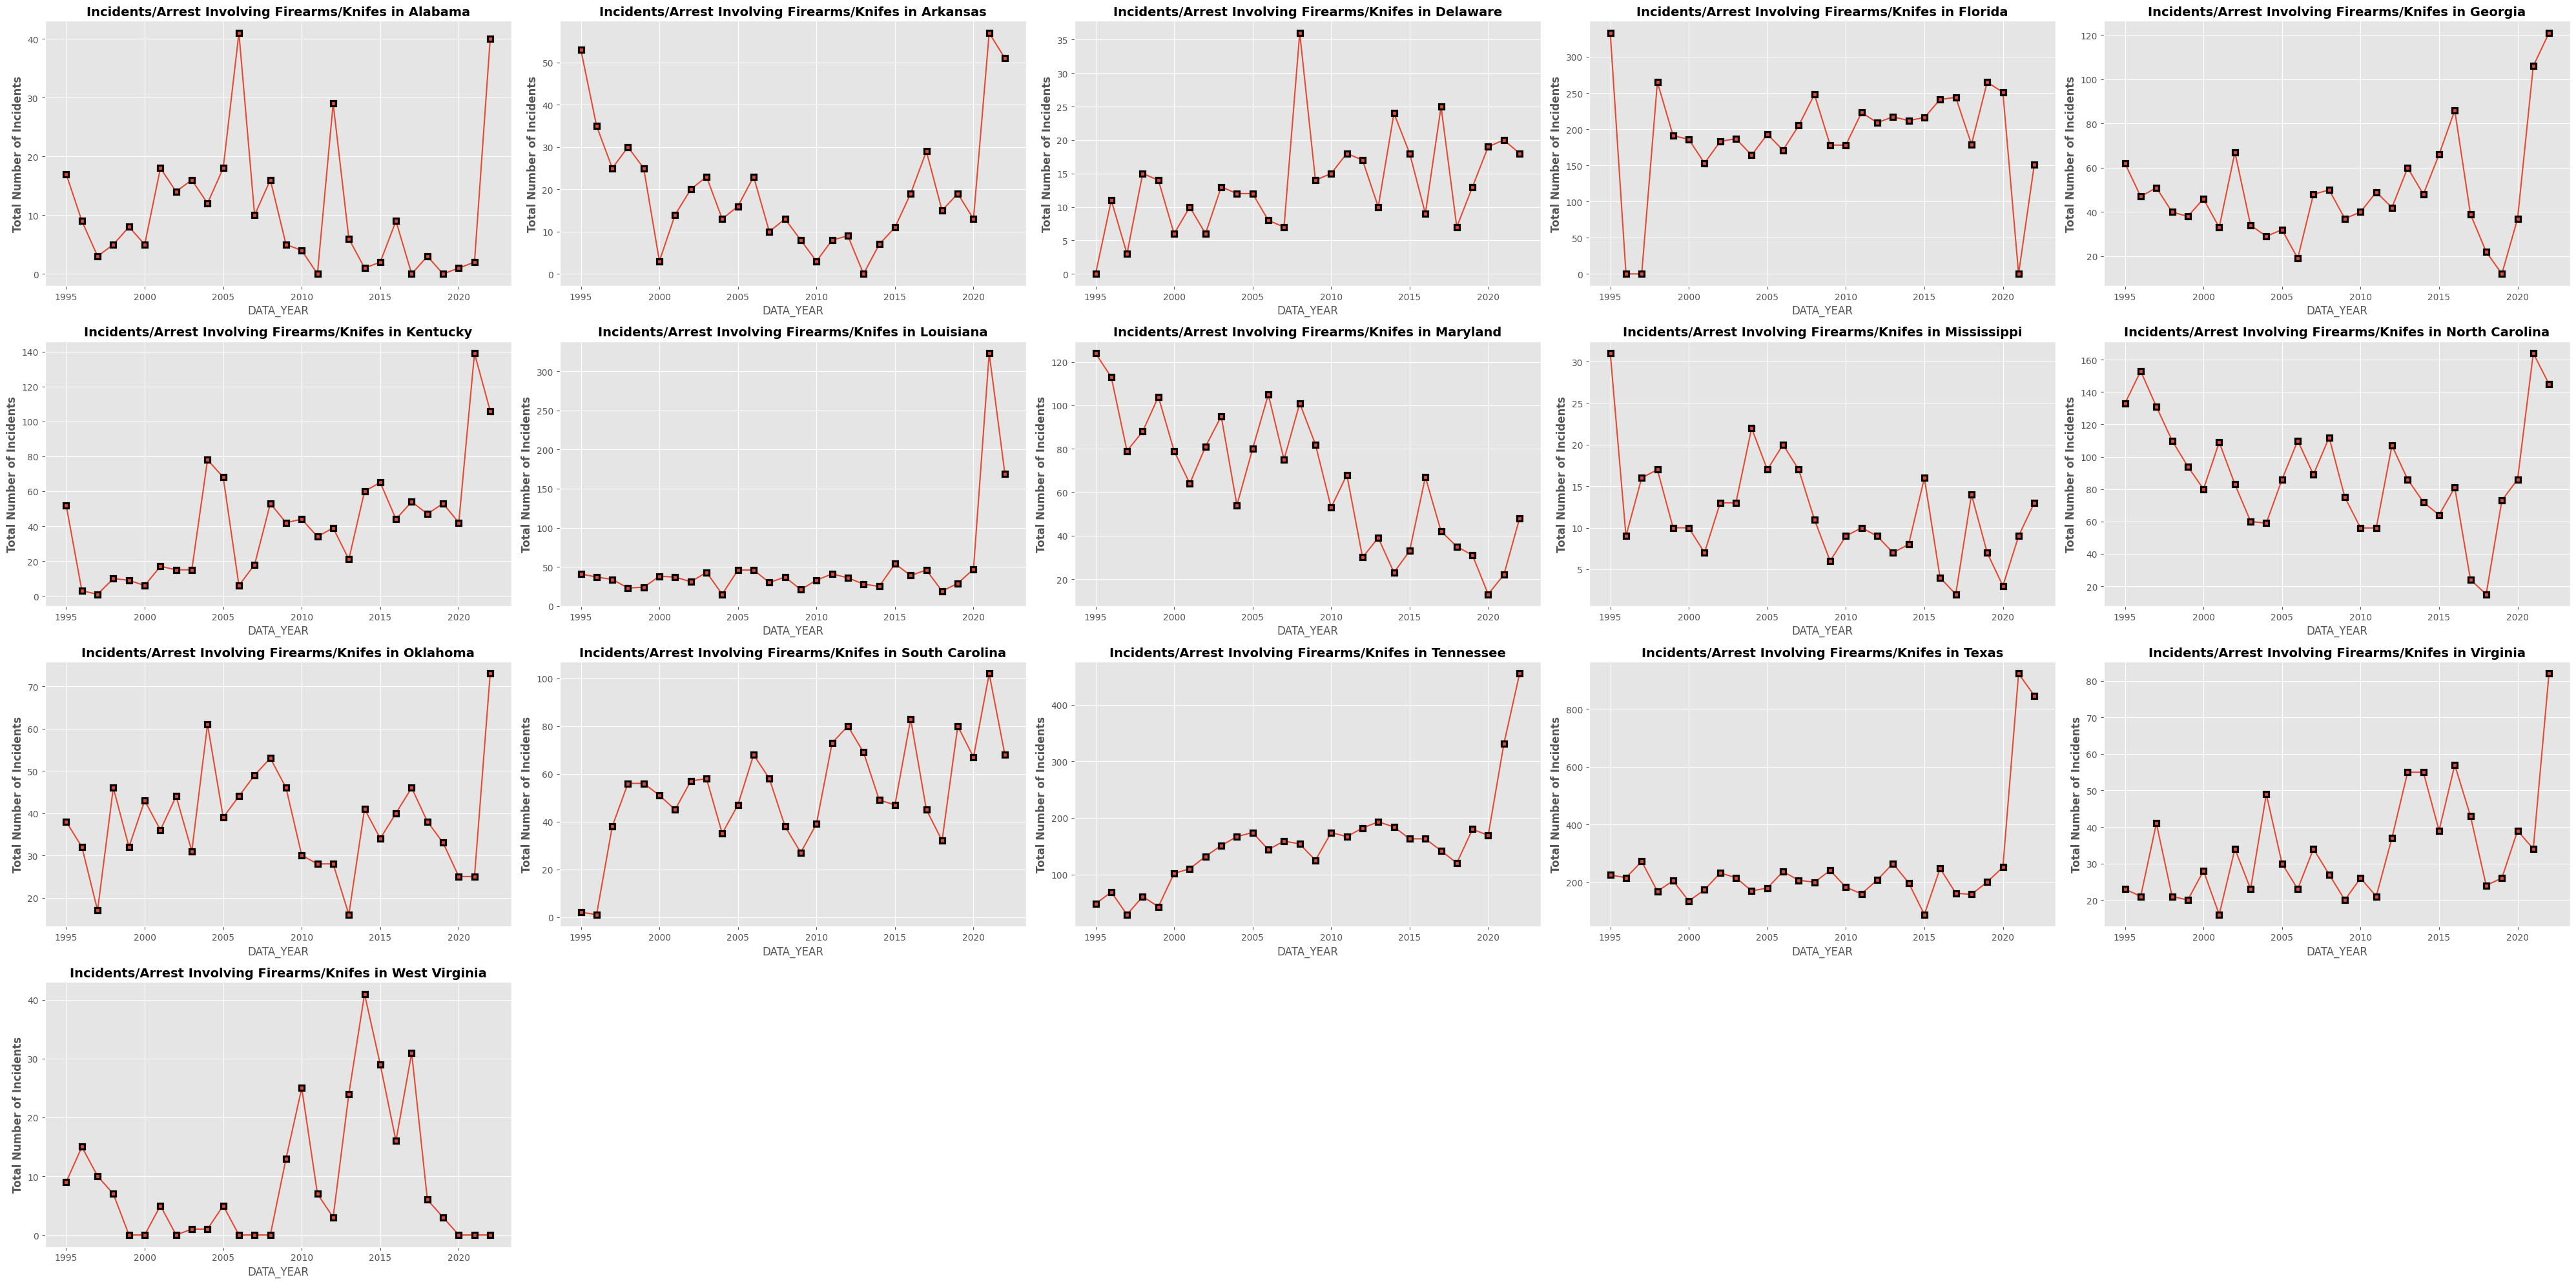

In [139]:
fig = plt.figure(figsize=(40,20))
for index,state in enumerate(states_south,1): 
    ax = fig.add_subplot(4,5,index)
    south_crime_summary[state].plot(ax=ax, marker='s', mec='black', mew=2.3)
    ax.set_title(f"Incidents/Arrest Involving Firearms/Knifes in {state}", fontweight='bold', fontsize=14)
    ax.set_ylabel("Total Number of Incidents", fontweight='bold')
plt.tight_layout() 

## **Assaults on Law Enforcement Officers in the South Region (Texas) and The Times `00:00` - `23:00` HRS**
- **Note**: Military time format, subtract by 12 to civilian times (e.g, 15:00 - 12:00 = 3 PM (Regular Times) )
- Most of these incidents occured early in the morning and night around ( `12 Am - 2 Am` and `10 Pm - 12 Am` )

In [187]:
incident_times: 'DataFrame' = assult_events.query("REGION_NAME == 'South' ").groupby(['DATA_YEAR', 'STATE'])[  list(filter(lambda row: 'TIME' in row, assult_events.columns.tolist() )) ].sum()
incident_times.columns = pd.Series(incident_times.columns).apply(lambda row: re.sub(r"TIME-", "TIME:",  row.replace("_CNT", "" ).replace("_", "-").strip()  ) ).tolist() 
texas_incident_times: 'DataFrame' = incident_times.loc[ list(filter(lambda row: row[1] == 'Texas' ,  incident_times.index.tolist())) ] 

timespan_categories: Dict = {1: 'Morning', 
                             2: 'Afternoon',
                             3: 'Evening',
                             4: 'Night'
                            }

texas_incident_times.index = list(range(1995, 2023)) 

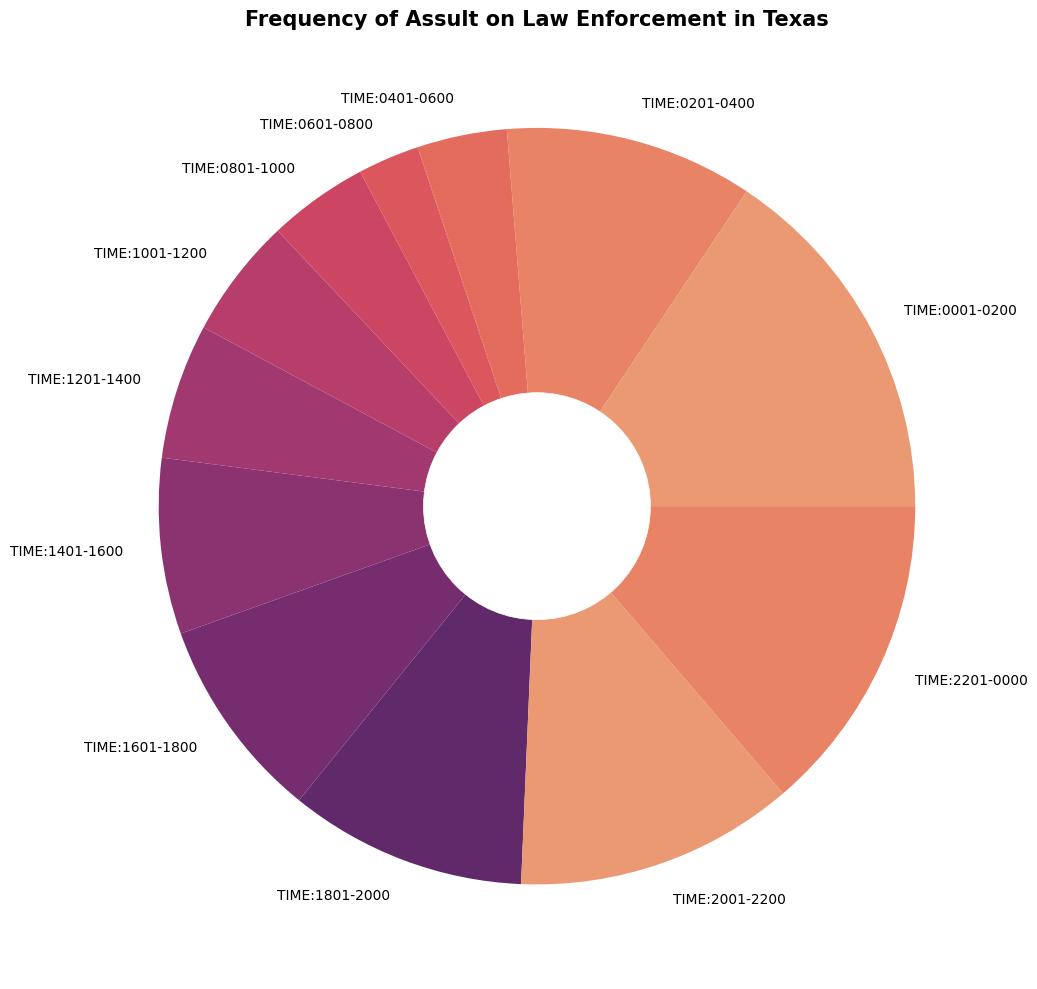

In [188]:
times, freqs = zip(*texas_incident_times.sum(axis=0).to_dict().items())
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot() 
ax.pie(x=list(freqs), labels=(times), colors=sns.color_palette(palette='flare', n_colors=10), rotatelabels=False)
plt.gcf().gca().add_artist(plt.Circle((0,0), radius=0.3, color='white' ))
ax.set_title(f"Frequency of Assult on Law Enforcement in Texas", fontweight='bold', fontsize=15)
plt.tight_layout() 

## **Trends in Assult on Law Enforcements in Texas**

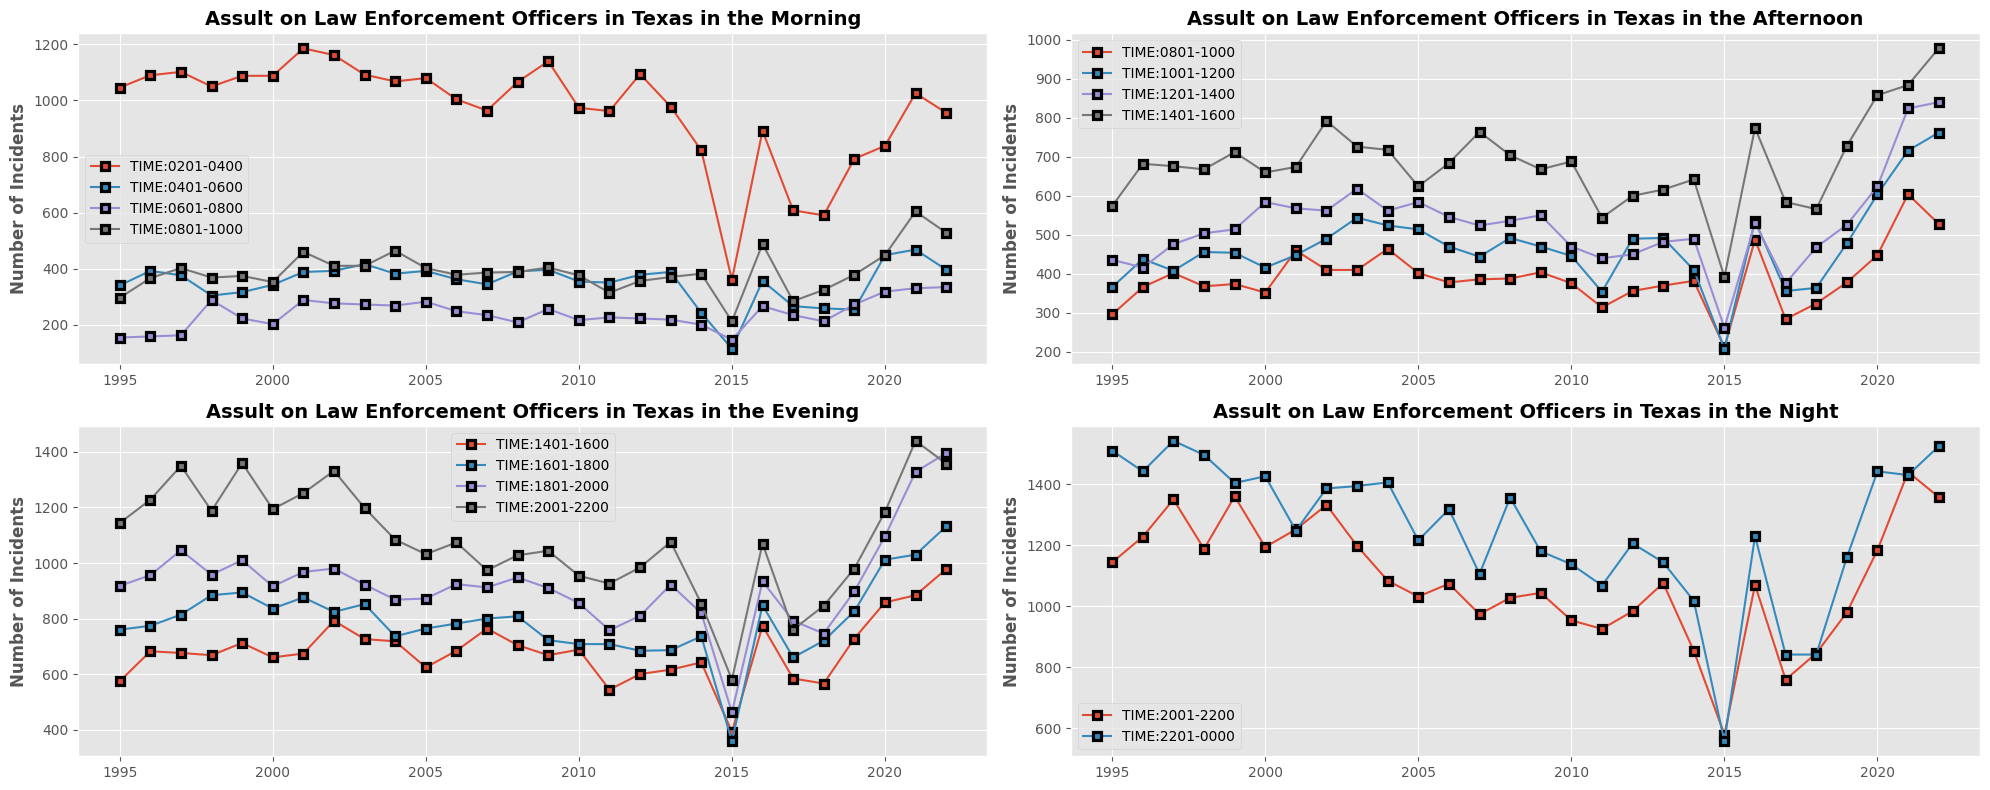

In [56]:
fig = plt.figure(figsize=(20,8)) 
row: int = 1 
for incident_times in [ texas_incident_times.columns.tolist()[index:index+4] for index in range(1,13,3) ]: 
    ax = fig.add_subplot(2,2, row) 
    texas_incident_times[incident_times].plot(ax=ax, marker='s', mec='black', mew=2.3) 
    ax.set_title(f"Assult on Law Enforcement Officers in Texas in the {timespan_categories.get(row)}", fontsize=14, fontweight='bold')
    row += 1
    ax.set_ylabel(f"Number of Incidents", fontweight='bold')


plt.tight_layout() 

## **Drugs Related Charges and Assult on Law Enforcements in Texas** 

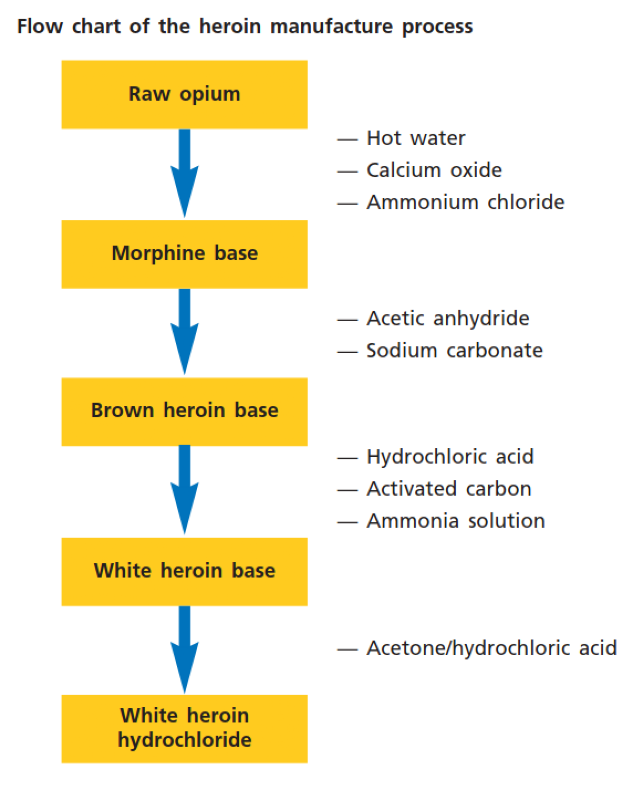

In [196]:
plt.rcParams['figure.figsize'] = (15,8)
plt.imshow( plt.imread("../images/heroin_manufacture_process.png") )
plt.axis('off')

plt.tight_layout()

In [108]:
con: sqlite3 = sqlite3.connect("../datasets/Texas/texas.db")
query: str = """
SELECT 
    DISTINCT 
    ni.incident_date, 
    ni.submission_date, 
    /* Reportig Agency */

    a.state_name,
    a.state_abbr,
    a.population,
    a.pub_agency_name,
    a.ncic_agency_name,
    a.ucr_agency_name,
    a.officer_rate,
    a.employee_rate,
    a.division_name,
    a.region_name,
    a.county_name,
    
    nv.age_num AS `victim_age_num`, 
    nv.sex_code AS `victim_sex_code`, 
    nv.age_range_low_num, 
    nv.age_code_range_high,
    ne.ethnicity_name AS `victim_ethnicity_name`,
    IFNULL(no.num_premises_entered, 0) AS `num_premises_entered`, 
    no.method_entry_code AS `entry_code`, 
    nt.offense_name, 
    nt.crime_against, 
    nt.offense_category_name, 
    nt.offense_group,
    IFNULL(np.stolen_count, 0) AS `stolen_count`, 
    IFNULL(np.recovered_count, 0) AS `recovered_count`,
    npd.data_year,
    npd.property_value, 
    npd.date_recovered,
    nsd.est_drug_qty, 
    nsdt.suspected_drug_name, 
    ndmt.drug_measure_name, 
    na.arrest_date, 
    na.age_num,
    na.sex_code,
    na.resident_code, 
    ne2.ethnicity_name AS `arrestee_ethnicity_name`,
    IFNULL(na.age_range_low_num,0) AS `age_range_low_num`,
    IFNULL(na.age_range_high_num, 0) AS `age_range_high_num`, 
    IFNULL(nwt.weapon_name, "N/A") AS `weapon_name`
    
FROM NIBRS_PROPERTY np 
JOIN NIBRS_PROPERTY_DESC npd ON npd.property_id = np.property_id
JOIN NIBRS_ARRESTEE na ON (na.incident_id = no.incident_id) AND ( na.offense_code = no.offense_code)
JOIN NIBRS_OFFENSE no ON no.incident_id = np.incident_id
JOIN NIBRS_OFFENSE_TYPE nt ON nt.offense_code = no.offense_code
JOIN NIBRS_VICTIM_OFFENSE nvo ON nvo.offense_id = no.offense_id AND nvo.data_year = no.data_year
JOIN NIBRS_VICTIM nv ON nv.victim_id = nvo.victim_id
JOIN NIBRS_ETHNICITY ne ON ne.ethnicity_id = nv.ethnicity_id
JOIN NIBRS_ETHNICITY ne2 ON ne2.ethnicity_id = na.ethnicity_id
JOIN NIBRS_SUSPECTED_DRUG nsd ON nsd.property_id = np.property_id
JOIN NIBRS_SUSPECTED_DRUG_TYPE nsdt ON nsdt.suspected_drug_type_id = nsd.suspected_drug_type_id
JOIN NIBRS_DRUG_MEASURE_TYPE ndmt ON ndmt.drug_measure_type_id = nsd.drug_measure_type_id
JOIN NIBRS_incident ni ON ni.incident_id = no.incident_id AND ni.data_year = no.data_year
JOIN agencies a ON a.agency_id = ni.agency_id AND a.data_year = ni.data_year
JOIN NIBRS_WEAPON nw ON nw.offense_id = no.offense_id AND nw.data_year = no.data_year
JOIN NIBRS_WEAPON_TYPE nwt ON nwt.weapon_id = nw.weapon_id 

"""
drugs_charges: 'DataFrame' = pd.read_sql(query, con=con)
drugs_charges['incident_date'] = pd.to_datetime( drugs_charges['incident_date'] )
drugs_charges['submission_date'] = pd.to_datetime( drugs_charges['submission_date'] , format='ISO8601') 
drugs_charges.head()

incident_date         submission_date state_name state_abbr  population  \
0    2022-03-25 2022-09-14 10:35:56.331      Texas         TX       19113   
1    2022-03-25 2022-09-14 10:35:56.331      Texas         TX       19113   
2    2022-03-25 2022-09-14 10:35:56.331      Texas         TX       19113   
3    2022-03-25 2022-09-14 10:35:56.331      Texas         TX       19113   
4    2022-05-21 2022-10-18 13:47:47.419      Texas         TX       19113   

  pub_agency_name       ncic_agency_name ucr_agency_name  officer_rate  \
0       Palestine  PALESTINE POLICE DEPT       PALESTINE           1.7   
1       Palestine  PALESTINE POLICE DEPT       PALESTINE           1.7   
2       Palestine  PALESTINE POLICE DEPT       PALESTINE           1.7   
3       Palestine  PALESTINE POLICE DEPT       PALESTINE           1.7   
4       Palestine  PALESTINE POLICE DEPT       PALESTINE           1.7   

   employee_rate       division_name region_name county_name victim_age_num  \
0            2.5  West South Central       South    ANDERSON             NS   
1            2.5  West South Central       South    ANDERSON             NS   
2            2.5  West South Central       South    ANDERSON             NS   
3            2.5  West South Central       South    ANDERSON             NS   
4            2.5  West South Central       South    ANDERSON             22   

  victim_sex_code  age_range_low_num  age_code_range_high  \
0               X                NaN                  NaN   
1               X                NaN                  NaN   
2               X                NaN                  NaN   
3               X                NaN                  NaN   
4               F               22.0                  NaN   

    victim_ethnicity_name  num_premises_entered entry_code  \
0           Not Specified                     0       None   
1           Not Specified                     0       None   
2           Not Specified                     0       None   
3           Not Specified                     0       None   
4  Not Hispanic or Latino                     0       None   

            offense_name crime_against  offense_category_name offense_group  \
0  Weapon Law Violations       Society  Weapon Law Violations             A   
1  Weapon Law Violations       Society  Weapon Law Violations             A   
2  Weapon Law Violations       Society  Weapon Law Violations             A   
3  Weapon Law Violations       Society  Weapon Law Violations             A   
4     Aggravated Assault        Person       Assault Offenses             A   

   stolen_count  recovered_count  data_year  property_value date_recovered  \
0             0                0       2022             NaN           None   
1             0                0       2022             NaN           None   
2             0                0       2022             1.0           None   
3             0                0       2022             1.0           None   
4             0                0       2022             NaN           None   

   est_drug_qty suspected_drug_name drug_measure_name arrest_date  age_num  \
0         2.190             Cocaine              Gram  2022-03-25       20   
1         6.115           Marijuana             Ounce  2022-03-25       20   
2         2.190             Cocaine              Gram  2022-03-25       20   
3         6.115           Marijuana             Ounce  2022-03-25       20   
4         0.240  Meth/ Amphetamines              Gram  2022-05-21       23   

  sex_code resident_code arrestee_ethnicity_name  age_range_low_num  \
0        M             R  Not Hispanic or Latino               20.0   
1        M             R  Not Hispanic or Latino               20.0   
2        M             R  Not Hispanic or Latino               20.0   
3        M             R  Not Hispanic or Latino               20.0   
4        M             R  Not Hispanic or Latino               23.0   

   age_range_high_num weapon_name  
0  

## **Types of Drugs Confiscated Durring the Arrest**

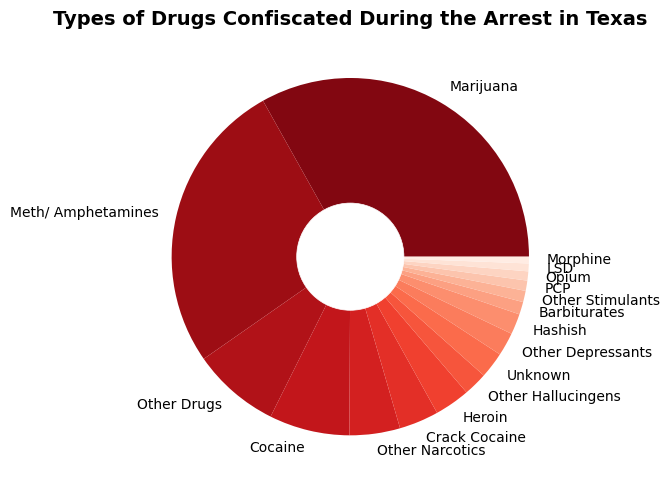

In [182]:
drug_types, freqs = zip(*drugs_charges.query("offense_category_name == 'Drug/Narcotic Offenses' " )['suspected_drug_name'].value_counts().to_dict().items())
tx_drug_types, tx_freqs = zip(*drugs_charges.query("state_name == 'Texas' and offense_category_name == 'Drug/Narcotic Offenses' ")['suspected_drug_name'].value_counts().to_dict().items())

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
ax.pie(x=list(tx_freqs[:-9]) + (np.array(tx_freqs[-9:]) + 1500 ).tolist() , labels=list(tx_drug_types), colors=sns.color_palette(palette='Reds_r', n_colors=len(drug_types) ))
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), color='white', radius=0.3 ) )
ax.set_title("Types of Drugs Confiscated During the Arrest in Texas", fontweight='bold', fontsize=14)

plt.tight_layout()

## **Trends in Confiscated Drugs in Texas Overtime**

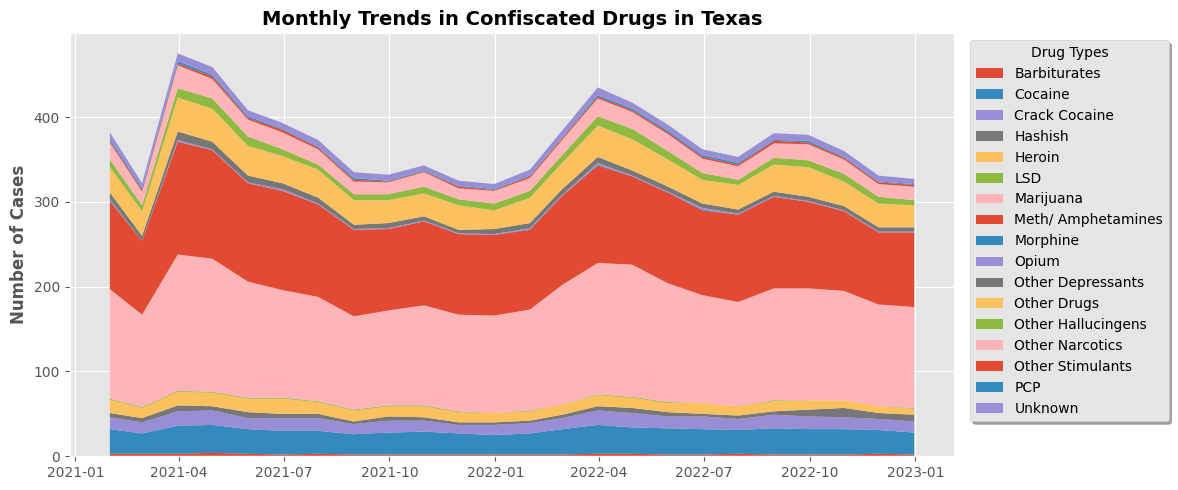

In [9]:
monthly_trends_tx: 'DataFrame' = drugs_charges.query("state_name == 'Texas' and offense_category_name == 'Drug/Narcotic Offenses' ").groupby(['incident_date', 'suspected_drug_name' ]).size().unstack('suspected_drug_name').replace({np.nan:0.0}).sort_index().resample("M").mean().applymap(lambda row: round(row) )

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot() 

ax.stackplot(monthly_trends_tx.index.tolist(),
             monthly_trends_tx['Barbiturates'] ,
             monthly_trends_tx['Cocaine'],
             monthly_trends_tx['Crack Cocaine'],
             monthly_trends_tx['Hashish'],
             monthly_trends_tx['Heroin'],
             monthly_trends_tx['LSD'],
             monthly_trends_tx['Marijuana'],
             monthly_trends_tx['Meth/ Amphetamines'],
             monthly_trends_tx['Morphine'],
             monthly_trends_tx['Opium'],
             monthly_trends_tx['Other Depressants'],
             monthly_trends_tx['Other Drugs'],
             monthly_trends_tx['Other Hallucingens'],
             monthly_trends_tx['Other Narcotics'],
             monthly_trends_tx['Other Stimulants'],
             monthly_trends_tx['PCP'],
             monthly_trends_tx['Unknown'], 
            labels=monthly_trends_tx.columns.tolist() )

ax.set_title("Monthly Trends in Confiscated Drugs in Texas", fontweight='bold', fontsize=14)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.legend(title="Drug Types", bbox_to_anchor=(1.25, 1), shadow=True, fancybox=True) 

plt.tight_layout()

## **Drug Possession, Ethnicity, and Arrest in Texas**
- **Unit Measure**: Gram

In [108]:
drugs_charges.query("offense_name == 'Drug/Narcotic Violations' and drug_measure_name == 'Gram' ").groupby(['suspected_drug_name', 'arrestee_ethnicity_name'])['est_drug_qty'].mean().unstack('arrestee_ethnicity_name').applymap(lambda row: "%s Gram" % (round(row,3)) )

arrestee_ethnicity_name Hispanic or Latino Not Hispanic or Latino  \
suspected_drug_name                                                 
Barbiturates                   15.311 Gram            11.061 Gram   
Cocaine                        58.621 Gram            50.551 Gram   
Crack Cocaine                   8.711 Gram             8.705 Gram   
Hashish                       125.984 Gram           274.025 Gram   
Heroin                         23.849 Gram            14.132 Gram   
LSD                             1.454 Gram             9.286 Gram   
Marijuana                     154.009 Gram           167.709 Gram   
Meth/ Amphetamines            543.905 Gram            24.557 Gram   
Morphine                        5.876 Gram             9.539 Gram   
Opium                         108.416 Gram             23.63 Gram   
Other Depressants              21.929 Gram            69.119 Gram   
Other Drugs                    95.081 Gram            59.777 Gram   
Other Hallucingens            103.657 Gram            85.467 Gram   
Other Narcotics                60.032 Gram            173.66 Gram   
Other Stimulants               33.814 Gram            29.991 Gram   
PCP                            28.931 Gram            15.649 Gram   
Unknown                        34.766 Gram           195.133 Gram   

arrestee_ethnicity_name Not Specified       Unknown  
suspected_drug_name                                  
Barbiturates              234.28 Gram    3.914 Gram  
Cocaine                   27.664 Gram   69.573 Gram  
Crack Cocaine             15.472 Gram    5.911 Gram  
Hashish                   112.44 Gram   35.407 Gram  
Heroin                    97.237 Gram    9.869 Gram  
LSD                         0.01 Gram     5.89 Gram  
Marijuana                 74.807 Gram  123.404 Gram  
Meth/ Amphetamines        87.327 Gram   34.916 Gram  
Morphine                     5.6 Gram    0.826 Gram  
Opium                      2.124 Gram   15.401 Gram  
Other Depressants         13.569 Gram   24.646 Gram  
Other Drugs               32.533 Gram   49.696 Gram  
Other Hallucingens         35.45 Gram   24.046 Gram  
Other Narcotics           21.075 Gram  706.991 Gram  
Other Stimulants           4.196 Gram    3.898 Gram  
PCP                        9.567 Gram    17.28 Gram  
Unknown                     8.13 Gram   25.339 Gram

## **Drug Possession, Ethnicity, and Arrest in Texas**
- **Unit Measure**: Kilogram

In [114]:
drugs_charges.query("offense_name == 'Drug/Narcotic Violations' and drug_measure_name == 'Kilogram' ").groupby(['suspected_drug_name', 'arrestee_ethnicity_name'])['est_drug_qty'].mean().unstack('arrestee_ethnicity_name').replace({np.nan:0.0}).applymap(lambda row: "%s Kg" % (round(row,3)) )

arrestee_ethnicity_name Hispanic or Latino Not Hispanic or Latino  \
suspected_drug_name                                                 
Barbiturates                        1.5 Kg                 0.0 Kg   
Cocaine                        1073.597 Kg             116.481 Kg   
Crack Cocaine                     5.418 Kg              120.67 Kg   
Hashish                           59.22 Kg                 0.0 Kg   
Heroin                          1335.12 Kg               2.489 Kg   
Marijuana                        29.762 Kg             130.811 Kg   
Meth/ Amphetamines               12.599 Kg             340.591 Kg   
Other Depressants                 22.22 Kg                1.09 Kg   
Other Drugs                         7.1 Kg             206.508 Kg   
Other Hallucingens                  6.0 Kg           50001.414 Kg   
Other Narcotics                   2.168 Kg              500.75 Kg   
Other Stimulants                    0.0 Kg                 1.0 Kg   
Unknown                          45.038 Kg              155.13 Kg   

arrestee_ethnicity_name Not Specified  
suspected_drug_name                    
Barbiturates                   0.0 Kg  
Cocaine                      1.207 Kg  
Crack Cocaine                  0.0 Kg  
Hashish                        0.0 Kg  
Heroin                         0.0 Kg  
Marijuana                    28.94 Kg  
Meth/ Amphetamines            21.0 Kg  
Other Depressants              0.0 Kg  
Other Drugs                    0.0 Kg  
Other Hallucingens             0.0 Kg  
Other Narcotics                0.0 Kg  
Other Stimulants               0.0 Kg  
Unknown                        0.0 Kg

## **Trends in Confiscated Drugs Submission to the `UCR Program`**  

In [63]:
submission_ucr: Dict = {**drugs_charges.query("offense_name == 'Drug/Narcotic Violations' and drug_measure_name == 'Kilogram' ").set_index('submission_date')['est_drug_qty'].apply(lambda row: row * 1e3).to_dict(), 
                       **drugs_charges.query("offense_name == 'Drug/Narcotic Violations' and drug_measure_name == 'Gram' and est_drug_qty < 1e5 ").set_index('submission_date')['est_drug_qty'].to_dict()  }

submission_ucr_df: 'DataFRame' = pd.DataFrame(list(submission_ucr.values()), index= list(submission_ucr.keys()))
submission_ucr_df = submission_ucr_df.rename({0: 'Unit Grams'}, axis=1)
submission_ucr_df['month'] = pd.Series(submission_ucr_df.index).apply(lambda row: row.month).tolist()
submission_ucr_df['month_name'] = pd.Series(submission_ucr_df.index).apply(lambda row: row.month_name() ).tolist()
submission_ucr_df['year'] = pd.Series(submission_ucr_df.index).apply(lambda row: row.year).tolist()

submission_ucr_df.head()

Unit Grams  month month_name  year
2022-11-14 19:55:54.839     6941.00     11   November  2022
2022-05-13 12:00:04.781  6000000.00      5        May  2022
2022-09-14 10:35:00.576     7000.00      9  September  2022
2022-03-14 10:59:15.666     1000.00      3      March  2022
2022-10-18 13:46:38.248        0.04     10    October  2022

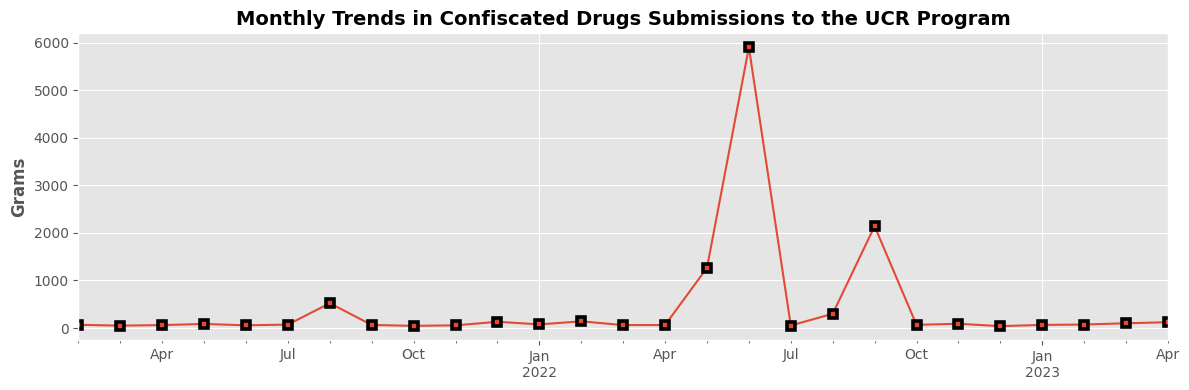

In [98]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot() 
submission_ucr_df.sort_index()['Unit Grams'].resample("M").mean().replace({np.nan:0.0} ).plot(ax=ax, mec='black', mew=2.6, marker='s')
ax.set_ylabel("Grams", fontweight='bold')
ax.set_title("Monthly Trends in Confiscated Drugs Submissions to the UCR Program", fontweight='bold', fontsize=14)

plt.tight_layout()

## **Total Confiscated Drugs by Month/Year Submitted to the UCR Program**

In [84]:
pd.DataFrame(submission_ucr_df.groupby('year')['Unit Grams'].sum().apply(lambda row: f"{row / 1e6:.3f} Kg" ) ).rename({'Unit Grams':'Unit Kg'})

Unit Grams
year           
2021   6.201 Kg
2022  48.481 Kg
2023   0.831 Kg

## **Total Confiscated Drugs by Month Submitted to the UCR Program**

In [97]:
pd.DataFrame( submission_ucr_df.groupby('month')['Unit Grams'].sum().apply(lambda row: row/1e6).apply(lambda row: f"{row:.3f} Kg")).rename(dict( submission_ucr_df[['month', 'month_name']].sort_values(by='month').drop_duplicates().apply(lambda row: (row['month'], row['month_name']) ,axis=1 ).tolist()), axis=0)

Unit Grams
month               
January     0.897 Kg
February    1.093 Kg
March       0.693 Kg
April       0.612 Kg
May         6.846 Kg
June       27.250 Kg
July        0.475 Kg
August      4.709 Kg
September  10.692 Kg
October     0.556 Kg
November    0.802 Kg
December    0.888 Kg

## **Number of Assaults on Law Enforcement Officers in the West Region**

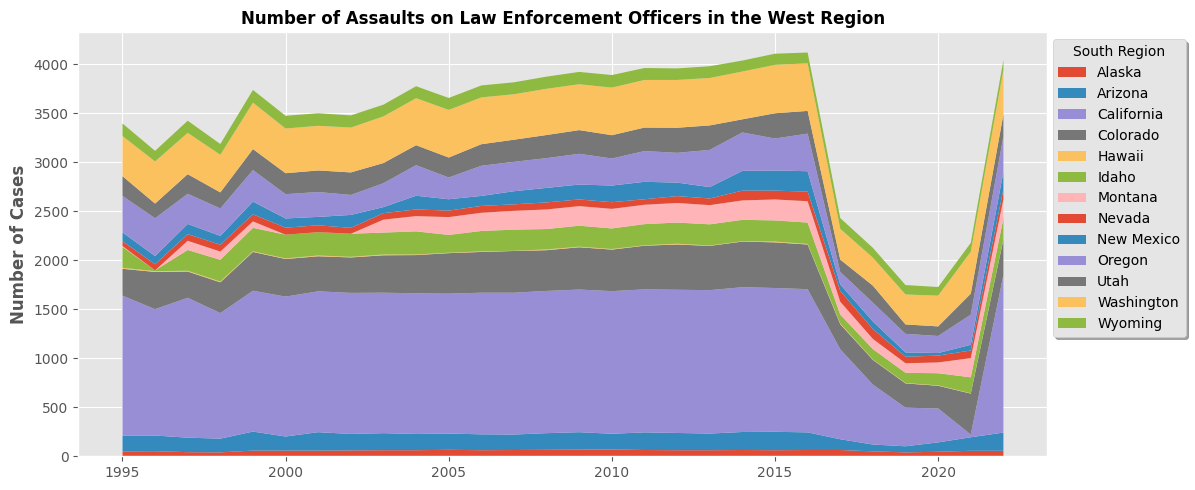

In [38]:
fig = plt.figure(figsize=(12,5)) 
ax = fig.add_subplot() 

west_region: 'DataFrame' = assult_events.query("REGION_NAME == 'West' ").groupby(['DATA_YEAR','STATE']).size().unstack('STATE').replace({np.nan:0.0})
ax.stackplot(west_region.index.tolist(),
             west_region['Alaska'].tolist(),
             west_region['Arizona'].tolist(),
             west_region['California'].tolist(),
             west_region['Colorado'].tolist(),
             west_region['Hawaii'].tolist(),
             west_region['Idaho'].tolist(),
             west_region['Montana'].tolist(),
             west_region['Nevada'].tolist(),
             west_region['New Mexico'].tolist(),
             west_region['Oregon'].tolist(),
             west_region['Utah'].tolist(),
             west_region['Washington'].tolist(),
             west_region['Wyoming'].tolist(), 
            labels=west_region.columns.tolist())# , 
            # colors=sns.color_palette(palette='flare', n_colors=15)) 

ax.set_title("Number of Assaults on Law Enforcement Officers in the West Region", fontweight='bold', fontsize=12)
ax.set_ylabel("Number of Cases", fontweight='bold')
ax.legend(title="South Region", fancybox=True, shadow=True, bbox_to_anchor=(1.15,1)) 
plt.tight_layout()

## **Cladestine Labs** 

In [15]:
# Merge all cladestine labs into one DB 
con_lab: sqlite3 = sqlite3.connect("../datasets/clandestine_labs/cl.db")
for csv_file in os.listdir("../datasets/clandestine_labs/"):
    if '.csv' in csv_file: 
        pd.read_csv(os.path.join("../datasets/clandestine_labs/", csv_file) ).to_sql("clandestine_labs", con=con_lab, if_exists='append')

In [17]:
con_lab: sqlite3 = sqlite3.connect("../datasets/clandestine_labs/cl.db")
labs_df: 'DataFrame' = pd.read_sql("""SELECT
                                        cl.state, 
                                        cl.county, 
                                        cl.city, 
                                        cl.address1 AS `address`, 
                                        cl.date
                                      FROM clandestine_labs cl""", con=con_lab)

labs_df['date'] = pd.to_datetime( labs_df['date'])
labs_df['month_name'] = labs_df['date'].apply(lambda row: row.month_name() )
labs_df['month'] = labs_df['date'].apply(lambda row: row.month )
labs_df.head()

state      county           city                   address        date
0   Alabama     Winston     Haleyville      135 County Road 3411  2019-01-08
1   Alabama     Autauga     Prattville  109 North Memorial Drive  2019-06-06
2    Kansas    Sedgwick        Wichita    1349 Summitlawn Street  2019-02-06
3    Kansas       Geary  Junction City       308 N Washington st  2019-06-15
4  Maryland  Washington   Williamsport      4 South Conocoheague  2019-03-14

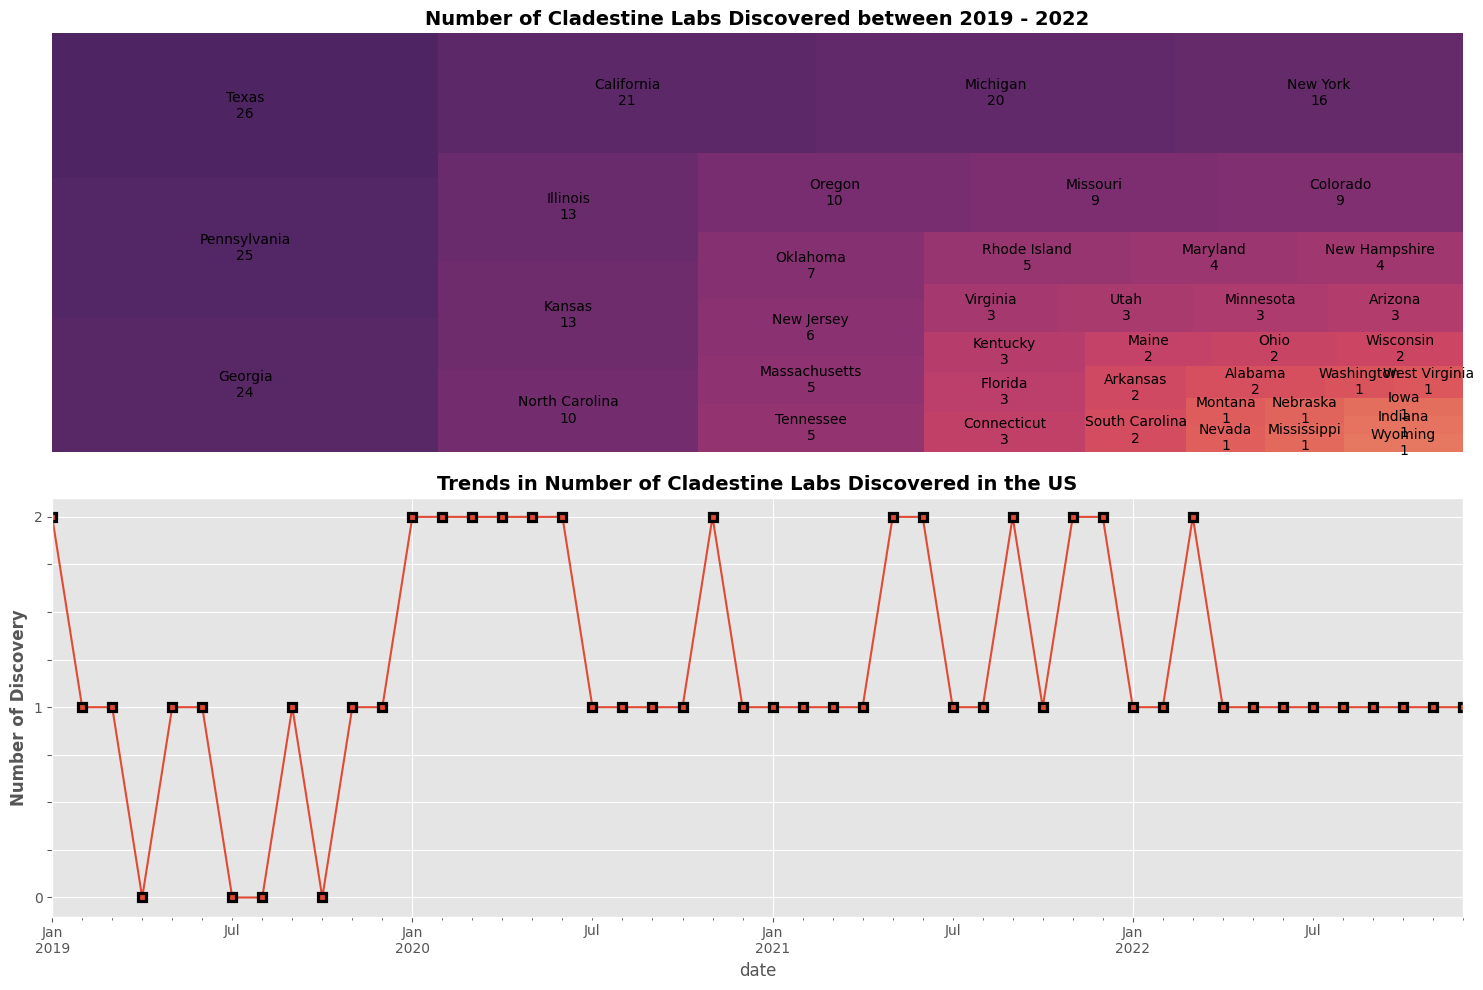

In [82]:
states, freqs = zip(*labs_df.groupby('state').size().sort_values(ascending=False).to_dict().items() )
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,1,1) 

sq.plot(sizes=list(freqs), label=list(map(lambda item: "%s\n%s" % (item[0], item[1]) , zip(states, freqs))),ax=ax, color=sns.color_palette(palette='flare_r', n_colors=52) )
ax.axis('off')
ax.set_title("Number of Cladestine Labs Discovered between 2019 - 2022", fontweight='bold', fontsize=14)
ax.invert_yaxis() 

ax = fig.add_subplot(2,1,2)
labs_df.groupby('date').size().sort_index().resample('M').mean().replace({np.nan:0.0}).apply(lambda row: round(row) ).plot(ax=ax,marker='s', mec='black', mew=2.3)
ax.set_title("Trends in Number of Cladestine Labs Discovered in the US", fontweight='bold', fontsize=14)
ax.set_yticklabels(['', 0,'', '', '', 1, '', '', '', 2])
ax.set_ylabel("Number of Discovery", fontweight='bold')
plt.tight_layout()

## **Confiscated Drug Types by Unit Measure in Texas**

In [86]:
pd.pivot_table(data=drugs_charges, columns='drug_measure_name', index='suspected_drug_name' , values='est_drug_qty', aggfunc='mean' ).replace({np.nan:0.0})

drug_measure_name     Dosage Unit  Fluid Ounce    Gallon        Gram  \
suspected_drug_name                                                    
Barbiturates            78.881603    49.049900  0.994333   15.837650   
Cocaine                 18.194549   102.593600  0.650727   51.193729   
Crack Cocaine            1.296296     0.796667  0.772750    8.966212   
Hashish                 52.647926     7.917055  0.000000  163.833070   
Heroin                  10.293589     1.986680  1.855000   17.116909   
LSD                  37183.859707     0.000000  0.000000    6.729969   
Marijuana               11.323175     2.836350  4.639037  149.525045   
Meth/ Amphetamines      15.043058     7.423979  4.469641  152.169515   
Morphine                 5.745245    21.270000  0.000000    8.199757   
Opium                  116.679087    11.700000  0.000000   41.816603   
Other Depressants       38.520814   334.734650  1.840600   43.334655   
Other Drugs            240.273596    73.569824  7.398952   71.650071   
Other Hallucingens      17.665763     2.649373  7.785000   81.543042   
Other Narcotics         54.826057    28.045329  4.113448  121.089621   
Other Stimulants        15.932268     2.380737  0.900500   29.421546   
PCP                      2.552632     0.625000  0.800000   17.175655   
Unknown                 12.448598    32.224018  1.000000  132.180275   

drug_measure_name        Kilogram    Liter     Milliliter  Not Reported  \
suspected_drug_name                                                       
Barbiturates             1.500000   1.0000      36.000000           1.0   
Cocaine                878.593944   1.0000   16193.261556           1.0   
Crack Cocaine           14.951909   0.0000   41570.703818           1.0   
Hashish                 21.745333   8.8720     134.882444           1.0   
Heroin                1243.163828   3.6435     355.462254           1.0   
LSD                      0.000000   0.0000       0.000000           1.0   
Marijuana               51.694802   0.0000  974926.161260           1.0   
Meth/ Amphetamines      96.940086  13.2490    2588.131054           1.0   
Morphine                 0.000000   0.0000      10.400000           0.0   
Opium                    0.000000   0.0000       4.360000           1.0   
Other Depressants        5.316000   0.0000    8105.729667           1.0   
Other Drugs             84.078923   1.4465    1119.109184           1.0   
Other Hallucingens   20003.238800   0.0000   23734.223962           1.0   
Other Narcotics        126.675750   2.0000    3525.639102           1.0   
Other Stimulants         1.000000   0.0000      38.676667           1.0   
PCP                      0.000000   0.0000    7064.325125           1.0   
Unknown                111.093300   5.0000    1758.705583           1.0   

drug_measure_name    Number of Plants       Ounce      Pound  
suspected_drug_name                                           
Barbiturates                 0.000000    0.809286   0.000000  
Cocaine                      0.000000    1.309191  11.403158  
Crack Cocaine                0.000000    0.617429   0.875000  
Hashish                      0.000000    7.626123  50.818857  
Heroin                       0.000000    4.395043   4.542353  
LSD                          0.000000    0.235800   1.100000  
Marijuana                    4.204963   31.800723  29.888869  
Meth/ Amphetamines           0.000000    1.753630  22.773648  
Morphine                     0.000000  109.695800   0.000000  
Opium                        0.000000   10.873600   0.000000  
Other Depressants            0.000000    4.114825   0.000000  
Other Drugs                  0.000000   12.461797  10.181289  
Other Hallucingens           0.000000    1.907931  23.478857  
Other Narcotics              0.000000    3.840098  10.861538  
Other Stimulants             0.000000    2.724909  14.440000  
PCP                          0.000000    2.927143   0.000000  
Unknown                      0.000000    5.955398  61.244000

## **Additional Drug Info (`DEA`)**

In [97]:
drug_info: 'DataFrame' = pd.read_excel("../datasets/clandestine_labs/DEA_LIMS_PublicUseFile (README)v4.xlsx", sheet_name='DATA') 
additional_info: 'DataFrame' = drug_info.groupby(['State', 'Drug Type' ])['Net Weight'].value_counts().unstack('Drug Type').replace({np.nan:0.0})
additional_info.loc[list(filter(lambda item: 'TX' == item[0] or 'AZ' == item[0] or 'CA' == item[0]  , additional_info.index.tolist() ))]

Drug Type           Cannabis  Cocaine  Fentanyl  Heroin  Methamphetamine  \
State Net Weight                                                           
AZ    10g-To-1000g     644.0    200.0     418.0   221.0            733.0   
      Over-1000g       469.0    221.0     208.0   149.0            599.0   
      Up-To-10g        203.0    279.0     269.0   158.0            578.0   
CA    10g-To-1000g    3324.0   2017.0    1320.0  1447.0           6740.0   
      Over-1000g      1572.0   1495.0     549.0   586.0           3339.0   
      Up-To-10g       2064.0   1984.0    1303.0   943.0           3548.0   
TX    10g-To-1000g    2124.0   3545.0     639.0  1547.0           9103.0   
      Over-1000g      3448.0   2189.0     185.0   602.0           3194.0   
      Up-To-10g        974.0   3480.0     600.0  1154.0           4456.0   

Drug Type            Other  
State Net Weight            
AZ    10g-To-1000g  1020.0  
      Over-1000g     111.0  
      Up-To-10g     1256.0  
CA    10g-To-1000g  4239.0  
      Over-1000g     656.0  
      Up-To-10g     4836.0  
TX    10g-To-1000g  4466.0  
      Over-1000g     488.0  
      Up-To-10g     5140.0

## **Counts of Drug Charges Offenses and Weapon Used during the Incident** 

In [118]:
drugs_charges.groupby(['suspected_drug_name', 'weapon_name']).size().unstack('weapon_name').replace({np.nan:0.0})

weapon_name          Asphyxiation  Blunt Object  \
suspected_drug_name                               
Barbiturates                  0.0           5.0   
Cocaine                       4.0          14.0   
Crack Cocaine                 2.0           7.0   
Hashish                       0.0          10.0   
Heroin                        0.0           4.0   
LSD                           0.0           1.0   
Marijuana                    35.0          85.0   
Meth/ Amphetamines            7.0          49.0   
Morphine                      0.0           0.0   
Opium                         0.0           1.0   
Other Depressants             1.0           9.0   
Other Drugs                   5.0          24.0   
Other Hallucingens            8.0          19.0   
Other Narcotics               0.0           9.0   
Other Stimulants              0.0           2.0   
PCP                           0.0           3.0   
Unknown                       8.0          11.0   

weapon_name          Drugs/Narcotics/Sleeping Pills  Explosives  \
suspected_drug_name                                               
Barbiturates                                    4.0         0.0   
Cocaine                                         4.0         0.0   
Crack Cocaine                                   1.0         0.0   
Hashish                                         0.0         0.0   
Heroin                                          1.0         0.0   
LSD                                             0.0         0.0   
Marijuana                                      23.0         2.0   
Meth/ Amphetamines                              9.0         0.0   
Morphine                                        0.0         0.0   
Opium                                           0.0         0.0   
Other Depressants                               0.0         0.0   
Other Drugs                                     7.0         0.0   
Other Hallucingens                              3.0         0.0   
Other Narcotics                                 7.0         0.0   
Other Stimulants                                0.0         0.0   
PCP                                             0.0         0.0   
Unknown                                         2.0         0.0   

weapon_name          Fire/Incendiary Device  Firearm  Firearm (Automatic)  \
suspected_drug_name                                                         
Barbiturates                            0.0     21.0                  1.0   
Cocaine                                 0.0    218.0                 14.0   
Crack Cocaine                           1.0    113.0                  1.0   
Hashish                                 0.0     45.0                  4.0   
Heroin                                  0.0     37.0                  2.0   
LSD                                     0.0      2.0                  0.0   
Marijuana                               4.0   2063.0                160.0   
Meth/ Amphetamines                      4.0    486.0                 52.0   
Morphine                                0.0      4.0                  0.0   
Opium                                   0.0     14.0                  0.0   
Other Depressants                       0.0     79.0                  4.0   
Other Drugs                             0.0    288.0                 48.0   
Other Hallucingens                      0.0     72.0                 22.0   
Other Narcotics                         0.0    116.0                  8.0   
Other Stimulants                        0.0     16.0                  6.0   
PCP                                     0.0     17.0                  0.0   
Unknown                                 0.0    154.0                 17.0   

weapon_name          Handgun  Handgun (Automatic)  Knife/Cutting Instrument  \
suspected_drug_name                                                           
Barbiturates            55.0                  7.0                       4.0   
Cocaine               1025.0                 16.0      

In [ ]:
# Human Trafficking: Sex Offenses and Prostitution Violations 

# **References** 
1. https://fieldsupport.dliflc.edu/products/cip/mexico/mexico.pdf
2. https://www.justice.gov/archive/ndic/pubs27/27513/border.htm
3. https://www.bbc.com/news/world-asia-67688413
4. https://www.unodc.org/roseap/uploads/documents/Publications/2023/Southeast_Asia_Opium_Survey_2023.pdf
5. https://www.unodc.org/documents/crop-monitoring/Afghanistan/Afghanistan_opium_survey_2023.pdf